In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [4]:
import nltk
# nltk.download("stopwords")
# nltk.download("wordnet")

In [5]:
import pandas as pd
tweets_csv = pd.read_csv("Data/twcs.csv")
tweets_csv.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [8]:
import numpy as np

tweets = tweets_csv.copy()

first_mask = tweets.in_response_to_tweet_id.isnull()
first_tweet_ids = tweets.loc[first_mask, "tweet_id"].values
tweet_conversation = pd.DataFrame({"tweet_id": first_tweet_ids, 
                                   "conversation_id": np.arange(first_tweet_ids.size) + 1}, 
                                  dtype="int64")

unmatched_tweets = tweets.loc[~first_mask, ["tweet_id", "in_response_to_tweet_id"]].astype("int64")

results = tweet_conversation.copy()

while not tweet_conversation.empty:
    merged = pd.merge(unmatched_tweets, tweet_conversation, how="left", left_on="in_response_to_tweet_id", right_on="tweet_id", 
                      suffixes=("", "_parent"))
    matched_mask = merged.tweet_id_parent.notnull()
    tweet_conversation = merged.loc[matched_mask, tweet_conversation.columns]
    results = results.append(tweet_conversation.copy(), ignore_index=True)
    unmatched_tweets = merged.loc[~matched_mask, unmatched_tweets.columns]

results["conversation_id"] = results.conversation_id.astype("int64")

tweets = pd.merge(tweets, results, on="tweet_id")

channels = tweets[~tweets.author_id.str.match(r"[0-9]+$")].groupby("conversation_id")["author_id"].first().to_frame("channel")
tweets = pd.merge(tweets, channels, left_on="conversation_id", right_index=True)

tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,channel
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,1,sprintcare
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1,sprintcare
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,1,sprintcare
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,1,sprintcare
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,1,sprintcare


In [9]:
tweets.groupby("channel").count().sort_values("conversation_id", ascending=False)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id
channel,,,,,,,,
AmazonHelp,370222,370222,370222,370222,370222,251311,288378,370222
AppleSupport,237443,237443,237443,237443,237443,149034,157129,237443
Uber_Support,127801,127801,127801,127801,127801,78613,86038,127801
SpotifyCares,91459,91459,91459,91459,91459,58757,63278,91459
Delta,86553,86553,86553,86553,86553,50899,60595,86553
AmericanAir,85822,85822,85822,85822,85822,54815,59757,85822
TMobileHelp,79242,79242,79242,79242,79242,49899,56762,79242
Tesco,71824,71824,71824,71824,71824,39682,55236,71824
comcastcares,71468,71468,71468,71468,71468,42432,47660,71468


In [10]:
conversations = tweets.groupby("conversation_id")["text"].apply(lambda s: s.str.cat(sep=" "))
conversations.head()

conversation_id
1    @115712 I understand. I would like to assist y...
2    @115713 This is saddening to hear. Please shoo...
3    @115715 Please send me a private message so th...
4    @115716 What information is incorrect? ^JK @As...
5    @115717 Hello, My apologies for any frustratio...
Name: text, dtype: object

In [18]:
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import defaultdict
from gensim.corpora import Dictionary

tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
url_pattern = re.compile(r"https\:\/\/t\.co\/[a-zA-Z0-9]+")
num_pattern = re.compile(r"[0-9]+$")

def get_cleaned_doc(doc):
    cleaned = url_pattern.sub("?", doc)
    cleaned = cleaned.lower()
    cleaned = tokenizer.tokenize(cleaned)
    cleaned = [word for word in cleaned if num_pattern.match(word) is None]
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned]
    cleaned = [word for word in cleaned if word not in stop]
    return cleaned

docs = [get_cleaned_doc(doc) for doc in conversations]

token_freq = defaultdict(int)
for doc in docs:
    for token in doc:
        token_freq[token] += 1

print("number of unique tokens: " + str(len(token_freq)))
print("tokens used only once: " + str(sum(freq == 1 for freq in token_freq.values())))

docs = [[token for token in doc if token_freq[token] > 1] for doc in docs]

dictionary = Dictionary(docs)

number of unique tokens: 332278
tokens used only once: 212504


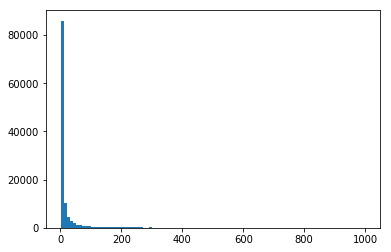

In [20]:
from matplotlib import pyplot as plt
plt.hist(dictionary.dfs.values(), bins=100, range=(1,1000));

In [ ]:
dictionary.filter_extremes(no_below=2, keep_n=None)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
from gensim.models import LdaModel
logging.getLogger().setLevel(logging.DEBUG) # checking convergence
lda = LdaModel(doc_term_matrix, id2word=dictionary, num_topics=108, alpha='auto', iterations=200, passes=1)
logging.getLogger().setLevel(logging.CRITICAL)

In [29]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda = models.LdaModel(doc_term_matrix, id2word=dictionary, num_topics=108, alpha='auto', iterations=200, passes=1)
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, mds="tsne")

PreparedData(topic_coordinates=           Freq  cluster  topics           x           y
topic                                                   
95     4.525218        1       1  -11.390786  -90.969734
43     3.975762        1       2  -21.401892  -65.763458
66     2.998756        1       3  -18.627064   29.327948
30     2.552471        1       4   56.876820   16.636814
100    2.233461        1       5  -42.894066  -77.829170
93     2.158924        1       6  109.351105   -2.892928
69     2.123574        1       7  138.214981  145.651703
55     2.100301        1       8   17.448286   68.963623
29     2.094453        1       9   83.492882   -1.166859
53     1.979488        1      10   77.141411  -52.170547
14     1.896665        1      11   30.824900   98.935295
98     1.713871        1      12  163.425781    8.143001
22     1.576864        1      13   94.955322   25.165350
46     1.522723        1      14   -3.107100  -66.979378
50     1.504253        1      15   55.847229  -37.888252
62     1.491033        1      16  -28.727242   -2.319631
105    1.437755        1      17  -16.051178   62.207443
81     1.415712        1      18  121.417633   27.341438
59     1.371904        1      19   21.994535  -85.153351
16     1.362895        1      20   59.803959   -5.504653
33     1.308797        1      21   23.224499   37.887794
56     1.246819        1      22 -178.329819  -34.555218
5      1.245727        1      23   80.713760   59.400082
87     1.245344        1      24  -70.563873   20.981649
94     1.208217        1      25  -19.674801 -116.818329
107    1.140859        1      26  -42.680023  -26.452627
49     1.100373        1      27   -6.580012  -36.681683
102    1.045288        1      28  -84.846146  111.531158
31     1.033478        1      29   59.377121  119.861717
75     0.996859        1      30  -43.054413   14.016874
...         ...      ...     ...         ...         ...
58     0.482482        1      79  137.022339  -27.421730
82     0.481520        1      80   -4.934471  -12.483421
84     0.481293        1      81 -116.224518  166.941666
57     0.480298        1      82 -199.000793   29.191303
52     0.478682        1      83  -65.989273 -201.557098
99     0.474661        1      84 -119.902428 -188.532959
3      0.468407        1      85  -57.586147 -143.983139
74     0.464925        1      86    2.789716   22.382095
68     0.462736        1      87   53.731167   80.892311
61     0.461884        1      88  -26.313406  -48.160023
34     0.459408        1      89  155.338257   50.841793
9      0.456979        1      90   19.309692  -64.379234
54     0.452478        1      91  -13.269553    9.205073
88     0.447886        1      92   96.750755 -143.609390
40     0.432718        1      93 -104.633507  -67.789810
12     0.428918        1      94   46.189075  -21.247255
104    0.428563        1      95   27.199348  -10.402430
97     0.421786        1      96  -23.050432  -23.015581
26     0.418424        1      97  212.389908   45.079979
6      0.407218        1      98  -57.331879  -48.146427
85     0.401762        1      99   59.128941 -218.429337
15     0.382280        1     100 -152.933304 -138.814056
47     0.364633        1     101  217.933212  -30.948833
101    0.357015        1     102   22.215807   12.381778
19     0.349803        1     103  156.720230 -138.000946
86     0.347175        1     104 -145.159714   37.096725
32     0.339849        1     105   12.178861  -40.404938
21     0.320927        1     106    2.218408 -214.351761
80     0.319374        1     107   10.204821  -21.166451
106    0.264589        1     108  173.101685  -58.529163

[108 rows x 5 columns], topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
247    Default  172048.000000         know  172048.000000  30.0000  30.0000
53     Default  332669.000000           dm  332669.000000  29.0000  29.0000
35     Default  480929.000000         

In [27]:
from gensim.models import LdaModel
logging.getLogger().setLevel(logging.DEBUG)
lda = LdaModel(doc_term_matrix, id2word=dictionary, num_topics=108, alpha='auto', iterations=200, passes=1)
logging.getLogger().setLevel(logging.CRITICAL)

2018-08-10 15:25:01,088 : INFO : using autotuned alpha, starting with [0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.009259259, 0.0092

2018-08-10 15:25:16,793 : DEBUG : 1999/2000 documents converged within 200 iterations
2018-08-10 15:25:16,856 : INFO : optimized alpha [0.009163093, 0.008822912, 0.00922568, 0.009257834, 0.009073127, 0.009338583, 0.009273926, 0.009339646, 0.009287613, 0.00931433, 0.00940781, 0.009364276, 0.009272812, 0.009308961, 0.0096560465, 0.0092910025, 0.009404715, 0.009182752, 0.008940719, 0.009046596, 0.00911429, 0.009391389, 0.009476132, 0.009280487, 0.0093956385, 0.009716412, 0.009269209, 0.009319351, 0.009774269, 0.009558207, 0.009313579, 0.009312138, 0.009079167, 0.009087246, 0.0094972, 0.00916804, 0.009225716, 0.009297396, 0.009304068, 0.009163716, 0.009244837, 0.008968592, 0.009229909, 0.009399986, 0.009329232, 0.009188044, 0.009330239, 0.009168684, 0.009417506, 0.00951185, 0.009462548, 0.009314615, 0.008939804, 0.009239489, 0.009049606, 0.009218808, 0.009022753, 0.009129161, 0.009171427, 0.009299986, 0.00946664, 0.009165312, 0.009334305, 0.009089125, 0.008958931, 0.009239912, 0.009236782,

2018-08-10 15:25:29,246 : INFO : topic #25 (0.010): 0.064*"british_airways" + 0.019*"wa" + 0.018*"staff" + 0.018*"hi" + 0.015*"sorry" + 0.014*"journey" + 0.012*"ba" + 0.010*"london" + 0.010*"coach" + 0.010*"hp"
2018-08-10 15:25:29,251 : INFO : topic #43 (0.011): 0.066*"applesupport" + 0.040*"u" + 0.031*"dm" + 0.030*"io" + 0.026*"iphone" + 0.024*"help" + 0.023*"let" + 0.020*"version" + 0.018*"update" + 0.014*"know"
2018-08-10 15:25:29,300 : INFO : topic diff=inf, rho=0.447214
2018-08-10 15:25:29,314 : INFO : PROGRESS: pass 0, at document #12000/794335
2018-08-10 15:25:29,314 : DEBUG : performing inference on a chunk of 2000 documents
2018-08-10 15:25:31,088 : DEBUG : 2000/2000 documents converged within 200 iterations
2018-08-10 15:25:31,166 : INFO : optimized alpha [0.009601692, 0.009040567, 0.009694495, 0.009595726, 0.00936674, 0.009715052, 0.009534352, 0.009874391, 0.009737941, 0.009947773, 0.009879977, 0.009686747, 0.0098440405, 0.009812537, 0.010381144, 0.009623527, 0.009805725, 0.

2018-08-10 15:25:43,886 : INFO : topic #1 (0.009): 0.038*"finally" + 0.036*"sad" + 0.029*"special" + 0.028*"perfect" + 0.025*"true" + 0.021*"atm" + 0.019*"good" + 0.019*"story" + 0.018*"like" + 0.017*"treat"
2018-08-10 15:25:43,902 : INFO : topic #41 (0.009): 0.119*"de" + 0.095*"que" + 0.079*"la" + 0.063*"el" + 0.061*"en" + 0.051*"por" + 0.047*"e" + 0.042*"un" + 0.042*"con" + 0.035*"lo"
2018-08-10 15:25:43,918 : INFO : topic #25 (0.011): 0.066*"british_airways" + 0.025*"staff" + 0.022*"journey" + 0.020*"hi" + 0.019*"wa" + 0.018*"sorry" + 0.016*"london" + 0.014*"ba" + 0.011*"rach" + 0.009*"would"
2018-08-10 15:25:43,918 : INFO : topic #29 (0.011): 0.040*"email" + 0.033*"received" + 0.027*"team" + 0.025*"please" + 0.021*"reply" + 0.017*"detail" + 0.016*"case" + 0.015*"response" + 0.015*"back" + 0.014*"form"
2018-08-10 15:25:43,933 : INFO : topic #43 (0.012): 0.058*"applesupport" + 0.045*"u" + 0.033*"dm" + 0.027*"io" + 0.027*"help" + 0.025*"iphone" + 0.024*"let" + 0.021*"version" + 0.020*

2018-08-10 15:26:00,887 : DEBUG : updating topics
2018-08-10 15:26:01,590 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:26:03,574 : INFO : topic #63 (0.009): 0.175*"sw_help" + 0.047*"mcdonalds" + 0.035*"door" + 0.024*"jw" + 0.023*"mb" + 0.022*"hi" + 0.020*"bin" + 0.015*"wa" + 0.014*"please" + 0.013*"service"
2018-08-10 15:26:03,590 : INFO : topic #32 (0.010): 0.082*"completely" + 0.067*"half" + 0.064*"fucking" + 0.053*"chicken" + 0.049*"im" + 0.048*"paying" + 0.026*"tier" + 0.025*"shitty" + 0.024*"upset" + 0.023*"internet"
2018-08-10 15:26:03,606 : INFO : topic #25 (0.012): 0.053*"british_airways" + 0.029*"staff" + 0.025*"journey" + 0.022*"hi" + 0.020*"london" + 0.020*"sorry" + 0.019*"wa" + 0.012*"ba" + 0.010*"hear" + 0.010*"would"
2018-08-10 15:26:03,621 : INFO : topic #29 (0.012): 0.047*"email" + 0.032*"received" + 0.025*"please" + 0.024*"team" + 0.023*"reply" + 0.017*"case" + 0.017*"back" + 0.015*"response" + 0.015*"detail" + 0.014*"pati

2018-08-10 15:26:16,361 : DEBUG : updating topics
2018-08-10 15:26:17,074 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:26:19,059 : INFO : topic #63 (0.010): 0.181*"sw_help" + 0.043*"door" + 0.030*"mb" + 0.026*"bin" + 0.023*"mcdonalds" + 0.023*"jw" + 0.019*"hi" + 0.017*"wa" + 0.016*"min" + 0.014*"please"
2018-08-10 15:26:19,074 : INFO : topic #56 (0.010): 0.103*"de" + 0.085*"amazonhelp" + 0.043*"vous" + 0.034*"un" + 0.034*"la" + 0.032*"en" + 0.029*"est" + 0.027*"à" + 0.027*"si" + 0.027*"que"
2018-08-10 15:26:19,090 : INFO : topic #25 (0.013): 0.058*"british_airways" + 0.027*"staff" + 0.023*"journey" + 0.022*"london" + 0.022*"hi" + 0.019*"sorry" + 0.018*"wa" + 0.015*"ba" + 0.010*"would" + 0.010*"kimbers"
2018-08-10 15:26:19,105 : INFO : topic #29 (0.013): 0.059*"email" + 0.033*"received" + 0.029*"team" + 0.026*"reply" + 0.025*"please" + 0.018*"patience" + 0.017*"back" + 0.016*"case" + 0.015*"response" + 0.015*"mail"
2018-08-10 15:26:19,121 :

2018-08-10 15:26:31,214 : DEBUG : updating topics
2018-08-10 15:26:31,903 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:26:33,871 : INFO : topic #63 (0.010): 0.150*"sw_help" + 0.052*"door" + 0.050*"mb" + 0.029*"bin" + 0.023*"jw" + 0.021*"min" + 0.019*"hi" + 0.017*"wa" + 0.017*"mcdonalds" + 0.015*"michelle"
2018-08-10 15:26:33,886 : INFO : topic #56 (0.010): 0.114*"de" + 0.078*"amazonhelp" + 0.055*"vous" + 0.042*"la" + 0.041*"en" + 0.037*"est" + 0.035*"un" + 0.033*"à" + 0.030*"que" + 0.028*"l"
2018-08-10 15:26:33,902 : INFO : topic #25 (0.013): 0.055*"british_airways" + 0.031*"staff" + 0.024*"journey" + 0.023*"hi" + 0.023*"london" + 0.022*"sorry" + 0.017*"wa" + 0.014*"ba" + 0.012*"hear" + 0.011*"would"
2018-08-10 15:26:33,917 : INFO : topic #29 (0.014): 0.061*"email" + 0.032*"received" + 0.028*"team" + 0.026*"please" + 0.026*"reply" + 0.018*"response" + 0.018*"form" + 0.017*"back" + 0.016*"case" + 0.015*"detail"
2018-08-10 15:26:33,933 : INF

2018-08-10 15:26:48,704 : DEBUG : updating topics
2018-08-10 15:26:49,418 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:26:51,374 : INFO : topic #63 (0.010): 0.128*"sw_help" + 0.056*"door" + 0.048*"mb" + 0.028*"min" + 0.026*"mcdonalds" + 0.025*"compliment" + 0.019*"bin" + 0.017*"hi" + 0.016*"front" + 0.016*"wa"
2018-08-10 15:26:51,389 : INFO : topic #24 (0.010): 0.050*"airasiasupport" + 0.048*"gt" + 0.039*"booking" + 0.034*"thanks" + 0.031*"hi" + 0.027*"flight" + 0.026*"check" + 0.014*"number" + 0.014*"may" + 0.012*"via"
2018-08-10 15:26:51,405 : INFO : topic #100 (0.014): 0.065*"dm" + 0.063*"address" + 0.049*"number" + 0.048*"please" + 0.039*"name" + 0.036*"full" + 0.033*"service" + 0.032*"account" + 0.031*"comcastcares" + 0.031*"phone"
2018-08-10 15:26:51,421 : INFO : topic #29 (0.015): 0.067*"email" + 0.036*"received" + 0.027*"reply" + 0.027*"team" + 0.026*"please" + 0.019*"case" + 0.018*"back" + 0.017*"response" + 0.017*"form" + 0.016*"

2018-08-10 15:27:02,280 : DEBUG : updating topics
2018-08-10 15:27:02,981 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:27:04,933 : INFO : topic #24 (0.010): 0.051*"booking" + 0.044*"airasiasupport" + 0.042*"gt" + 0.036*"thanks" + 0.032*"hi" + 0.028*"check" + 0.025*"flight" + 0.013*"number" + 0.013*"via" + 0.013*"thank"
2018-08-10 15:27:04,949 : INFO : topic #41 (0.010): 0.099*"de" + 0.092*"que" + 0.069*"el" + 0.066*"e" + 0.064*"la" + 0.055*"por" + 0.046*"para" + 0.042*"con" + 0.040*"en" + 0.034*"lo"
2018-08-10 15:27:04,965 : INFO : topic #100 (0.014): 0.069*"dm" + 0.059*"address" + 0.049*"please" + 0.043*"number" + 0.038*"name" + 0.035*"full" + 0.034*"service" + 0.031*"comcastcares" + 0.031*"account" + 0.028*"look"
2018-08-10 15:27:04,980 : INFO : topic #29 (0.015): 0.073*"email" + 0.036*"received" + 0.029*"please" + 0.026*"team" + 0.024*"case" + 0.023*"reply" + 0.023*"mail" + 0.021*"detail" + 0.019*"__email__" + 0.018*"form"
2018-08-10 15

2018-08-10 15:27:15,549 : DEBUG : updating topics
2018-08-10 15:27:16,246 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:27:18,199 : INFO : topic #24 (0.010): 0.049*"booking" + 0.036*"thanks" + 0.033*"check" + 0.032*"airasiasupport" + 0.031*"gt" + 0.030*"hi" + 0.025*"flight" + 0.015*"proceed" + 0.015*"may" + 0.014*"via"
2018-08-10 15:27:18,215 : INFO : topic #41 (0.010): 0.093*"de" + 0.087*"que" + 0.075*"el" + 0.065*"la" + 0.065*"e" + 0.055*"por" + 0.051*"para" + 0.048*"con" + 0.038*"en" + 0.035*"lo"
2018-08-10 15:27:18,230 : INFO : topic #100 (0.015): 0.073*"dm" + 0.061*"address" + 0.049*"please" + 0.041*"number" + 0.041*"name" + 0.035*"full" + 0.033*"service" + 0.030*"account" + 0.030*"look" + 0.028*"comcastcares"
2018-08-10 15:27:18,246 : INFO : topic #29 (0.016): 0.077*"email" + 0.039*"received" + 0.029*"please" + 0.028*"reply" + 0.027*"team" + 0.024*"case" + 0.020*"mail" + 0.019*"detail" + 0.019*"back" + 0.018*"response"
2018-08-10 15:2

2018-08-10 15:27:28,871 : DEBUG : updating topics
2018-08-10 15:27:29,563 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:27:31,683 : INFO : topic #24 (0.010): 0.053*"booking" + 0.040*"check" + 0.032*"thanks" + 0.030*"hi" + 0.023*"flight" + 0.022*"airasiasupport" + 0.022*"gt" + 0.015*"may" + 0.015*"assisted" + 0.015*"proceed"
2018-08-10 15:27:31,699 : INFO : topic #41 (0.010): 0.083*"de" + 0.083*"que" + 0.078*"el" + 0.071*"la" + 0.064*"e" + 0.056*"por" + 0.046*"con" + 0.044*"para" + 0.042*"en" + 0.034*"lo"
2018-08-10 15:27:31,715 : INFO : topic #100 (0.016): 0.072*"dm" + 0.058*"address" + 0.047*"please" + 0.040*"name" + 0.039*"number" + 0.033*"full" + 0.033*"service" + 0.033*"comcastcares" + 0.031*"account" + 0.029*"look"
2018-08-10 15:27:31,731 : INFO : topic #29 (0.017): 0.076*"email" + 0.038*"received" + 0.030*"please" + 0.027*"reply" + 0.026*"team" + 0.024*"case" + 0.021*"mail" + 0.020*"response" + 0.019*"back" + 0.019*"detail"
2018-08-10

2018-08-10 15:27:44,762 : DEBUG : updating topics
2018-08-10 15:27:45,454 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:27:47,497 : INFO : topic #24 (0.010): 0.049*"booking" + 0.043*"check" + 0.032*"thanks" + 0.030*"hi" + 0.019*"flight" + 0.019*"airasiasupport" + 0.017*"proceed" + 0.017*"assisted" + 0.015*"pr" + 0.015*"gt"
2018-08-10 15:27:47,512 : INFO : topic #41 (0.010): 0.082*"la" + 0.080*"el" + 0.079*"que" + 0.077*"de" + 0.060*"e" + 0.057*"por" + 0.045*"para" + 0.044*"en" + 0.042*"con" + 0.034*"lo"
2018-08-10 15:27:47,528 : INFO : topic #66 (0.016): 0.071*"customer" + 0.062*"service" + 0.028*"u" + 0.024*"wa" + 0.024*"experience" + 0.020*"sorry" + 0.016*"time" + 0.016*"like" + 0.015*"help" + 0.013*"told"
2018-08-10 15:27:47,544 : INFO : topic #29 (0.018): 0.072*"email" + 0.037*"received" + 0.030*"please" + 0.029*"reply" + 0.027*"team" + 0.022*"response" + 0.021*"case" + 0.020*"back" + 0.020*"form" + 0.018*"mail"
2018-08-10 15:27:47,559 

2018-08-10 15:27:57,943 : DEBUG : updating topics
2018-08-10 15:27:58,641 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:28:00,609 : INFO : topic #24 (0.010): 0.049*"booking" + 0.048*"check" + 0.029*"thanks" + 0.029*"hi" + 0.026*"ed" + 0.019*"pr" + 0.018*"flight" + 0.017*"proceed" + 0.015*"assisted" + 0.014*"may"
2018-08-10 15:28:00,625 : INFO : topic #41 (0.010): 0.084*"el" + 0.080*"la" + 0.078*"de" + 0.075*"que" + 0.054*"e" + 0.053*"por" + 0.046*"para" + 0.044*"con" + 0.042*"en" + 0.037*"lo"
2018-08-10 15:28:00,640 : INFO : topic #66 (0.017): 0.073*"customer" + 0.066*"service" + 0.029*"u" + 0.025*"experience" + 0.024*"wa" + 0.020*"sorry" + 0.017*"like" + 0.016*"time" + 0.015*"help" + 0.014*"told"
2018-08-10 15:28:00,661 : INFO : topic #29 (0.018): 0.075*"email" + 0.036*"received" + 0.029*"please" + 0.027*"reply" + 0.027*"team" + 0.022*"response" + 0.022*"case" + 0.020*"back" + 0.018*"mail" + 0.018*"detail"
2018-08-10 15:28:00,664 : INFO : 

2018-08-10 15:28:10,679 : DEBUG : updating topics
2018-08-10 15:28:11,377 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:28:13,325 : INFO : topic #24 (0.010): 0.046*"check" + 0.046*"booking" + 0.032*"hi" + 0.029*"thanks" + 0.024*"airasiasupport" + 0.019*"ed" + 0.019*"assisted" + 0.019*"proceed" + 0.018*"pr" + 0.017*"flight"
2018-08-10 15:28:13,341 : INFO : topic #41 (0.010): 0.081*"la" + 0.078*"de" + 0.075*"que" + 0.074*"el" + 0.055*"e" + 0.051*"por" + 0.045*"en" + 0.044*"con" + 0.043*"para" + 0.041*"mi"
2018-08-10 15:28:13,357 : INFO : topic #66 (0.018): 0.077*"customer" + 0.071*"service" + 0.029*"u" + 0.026*"experience" + 0.024*"wa" + 0.021*"sorry" + 0.017*"like" + 0.016*"help" + 0.016*"time" + 0.015*"told"
2018-08-10 15:28:13,372 : INFO : topic #29 (0.019): 0.076*"email" + 0.038*"received" + 0.029*"please" + 0.027*"team" + 0.027*"reply" + 0.022*"response" + 0.021*"case" + 0.020*"mail" + 0.019*"back" + 0.018*"detail"
2018-08-10 15:28:13,38

2018-08-10 15:28:26,310 : DEBUG : updating topics
2018-08-10 15:28:27,012 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:28:28,980 : INFO : topic #24 (0.010): 0.051*"check" + 0.050*"booking" + 0.035*"hi" + 0.025*"thanks" + 0.022*"airasiasupport" + 0.019*"pr" + 0.019*"per" + 0.016*"proceed" + 0.016*"ed" + 0.015*"passport"
2018-08-10 15:28:28,996 : INFO : topic #41 (0.010): 0.079*"de" + 0.076*"que" + 0.074*"la" + 0.073*"el" + 0.061*"e" + 0.053*"por" + 0.045*"para" + 0.042*"con" + 0.040*"en" + 0.038*"lo"
2018-08-10 15:28:29,011 : INFO : topic #66 (0.019): 0.081*"customer" + 0.074*"service" + 0.030*"u" + 0.025*"experience" + 0.025*"wa" + 0.020*"sorry" + 0.017*"like" + 0.015*"help" + 0.015*"told" + 0.015*"time"
2018-08-10 15:28:29,027 : INFO : topic #29 (0.020): 0.074*"email" + 0.038*"received" + 0.029*"reply" + 0.028*"please" + 0.026*"team" + 0.023*"response" + 0.020*"case" + 0.019*"mail" + 0.019*"back" + 0.018*"soon"
2018-08-10 15:28:29,042 : I

2018-08-10 15:28:38,840 : DEBUG : updating topics
2018-08-10 15:28:39,538 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:28:41,501 : INFO : topic #24 (0.010): 0.052*"booking" + 0.050*"check" + 0.033*"hi" + 0.026*"per" + 0.025*"thanks" + 0.019*"pr" + 0.019*"di" + 0.017*"airasiasupport" + 0.016*"proceed" + 0.016*"may"
2018-08-10 15:28:41,516 : INFO : topic #41 (0.010): 0.078*"de" + 0.076*"que" + 0.075*"el" + 0.074*"la" + 0.061*"e" + 0.049*"por" + 0.043*"para" + 0.042*"con" + 0.036*"en" + 0.036*"mi"
2018-08-10 15:28:41,532 : INFO : topic #66 (0.020): 0.083*"customer" + 0.077*"service" + 0.030*"experience" + 0.029*"u" + 0.024*"wa" + 0.022*"sorry" + 0.016*"like" + 0.015*"help" + 0.015*"time" + 0.014*"told"
2018-08-10 15:28:41,547 : INFO : topic #29 (0.021): 0.074*"email" + 0.037*"received" + 0.027*"reply" + 0.027*"please" + 0.026*"team" + 0.024*"response" + 0.020*"case" + 0.019*"back" + 0.019*"soon" + 0.018*"mail"
2018-08-10 15:28:41,563 : INFO :

2018-08-10 15:28:51,015 : DEBUG : updating topics
2018-08-10 15:28:51,714 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:28:53,682 : INFO : topic #24 (0.010): 0.052*"booking" + 0.041*"check" + 0.033*"hi" + 0.026*"thanks" + 0.026*"airasiasupport" + 0.025*"per" + 0.020*"pr" + 0.017*"proceed" + 0.017*"may" + 0.016*"ed"
2018-08-10 15:28:53,684 : INFO : topic #41 (0.011): 0.077*"de" + 0.076*"la" + 0.073*"que" + 0.071*"el" + 0.060*"e" + 0.051*"para" + 0.050*"por" + 0.042*"con" + 0.035*"en" + 0.034*"lo"
2018-08-10 15:28:53,699 : INFO : topic #29 (0.021): 0.078*"email" + 0.050*"response" + 0.037*"received" + 0.029*"reply" + 0.026*"please" + 0.024*"team" + 0.021*"case" + 0.019*"mail" + 0.018*"back" + 0.016*"form"
2018-08-10 15:28:53,715 : INFO : topic #69 (0.021): 0.172*"know" + 0.170*"let" + 0.115*"u" + 0.050*"help" + 0.035*"issue" + 0.027*"please" + 0.027*"need" + 0.024*"fixed" + 0.015*"hear" + 0.014*"future"
2018-08-10 15:28:53,731 : INFO : topic 

2018-08-10 15:29:07,017 : DEBUG : updating topics
2018-08-10 15:29:07,730 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:29:09,683 : INFO : topic #41 (0.011): 0.076*"que" + 0.075*"el" + 0.073*"de" + 0.072*"la" + 0.059*"e" + 0.053*"con" + 0.050*"por" + 0.046*"para" + 0.037*"lo" + 0.035*"en"
2018-08-10 15:29:09,699 : INFO : topic #24 (0.011): 0.059*"booking" + 0.039*"hi" + 0.038*"check" + 0.036*"airasiasupport" + 0.029*"per" + 0.029*"thanks" + 0.020*"di" + 0.017*"date" + 0.016*"ed" + 0.016*"may"
2018-08-10 15:29:09,714 : INFO : topic #66 (0.023): 0.086*"customer" + 0.079*"service" + 0.029*"experience" + 0.028*"u" + 0.026*"wa" + 0.022*"sorry" + 0.016*"help" + 0.015*"like" + 0.015*"time" + 0.013*"told"
2018-08-10 15:29:09,730 : INFO : topic #69 (0.023): 0.182*"know" + 0.175*"let" + 0.120*"u" + 0.051*"help" + 0.034*"issue" + 0.028*"please" + 0.027*"need" + 0.021*"fixed" + 0.014*"hear" + 0.014*"future"
2018-08-10 15:29:09,745 : INFO : topic #43 (0

2018-08-10 15:29:20,169 : DEBUG : updating topics
2018-08-10 15:29:20,948 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:29:22,902 : INFO : topic #41 (0.011): 0.079*"que" + 0.077*"el" + 0.072*"de" + 0.070*"la" + 0.060*"e" + 0.056*"por" + 0.049*"con" + 0.044*"para" + 0.037*"lo" + 0.035*"en"
2018-08-10 15:29:22,917 : INFO : topic #24 (0.011): 0.066*"airasiasupport" + 0.055*"booking" + 0.041*"hi" + 0.029*"thanks" + 0.029*"check" + 0.025*"per" + 0.022*"flight" + 0.015*"number" + 0.015*"may" + 0.013*"proceed"
2018-08-10 15:29:22,933 : INFO : topic #66 (0.024): 0.086*"customer" + 0.075*"service" + 0.033*"experience" + 0.027*"u" + 0.026*"wa" + 0.021*"sorry" + 0.016*"help" + 0.016*"like" + 0.015*"time" + 0.014*"told"
2018-08-10 15:29:22,949 : INFO : topic #43 (0.024): 0.075*"applesupport" + 0.041*"u" + 0.036*"dm" + 0.034*"iphone" + 0.031*"io" + 0.027*"help" + 0.023*"update" + 0.023*"phone" + 0.019*"let" + 0.017*"look"
2018-08-10 15:29:22,964 : INFO 

2018-08-10 15:29:33,261 : DEBUG : updating topics
2018-08-10 15:29:34,014 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:29:36,000 : INFO : topic #41 (0.011): 0.086*"el" + 0.083*"que" + 0.069*"la" + 0.068*"de" + 0.059*"e" + 0.056*"por" + 0.054*"con" + 0.040*"en" + 0.040*"para" + 0.038*"lo"
2018-08-10 15:29:36,016 : INFO : topic #24 (0.011): 0.068*"airasiasupport" + 0.051*"booking" + 0.043*"hi" + 0.028*"per" + 0.027*"check" + 0.027*"thanks" + 0.022*"flight" + 0.017*"may" + 0.016*"di" + 0.016*"number"
2018-08-10 15:29:36,031 : INFO : topic #43 (0.025): 0.071*"applesupport" + 0.041*"u" + 0.036*"iphone" + 0.034*"dm" + 0.029*"io" + 0.025*"help" + 0.023*"update" + 0.022*"phone" + 0.018*"let" + 0.017*"look"
2018-08-10 15:29:36,047 : INFO : topic #66 (0.025): 0.089*"customer" + 0.078*"service" + 0.032*"experience" + 0.027*"wa" + 0.026*"u" + 0.020*"sorry" + 0.016*"like" + 0.016*"told" + 0.016*"help" + 0.015*"time"
2018-08-10 15:29:36,063 : INFO : top

2018-08-10 15:29:45,718 : DEBUG : updating topics
2018-08-10 15:29:46,414 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:29:48,401 : INFO : topic #41 (0.011): 0.090*"el" + 0.082*"que" + 0.072*"la" + 0.064*"de" + 0.061*"por" + 0.060*"e" + 0.056*"con" + 0.041*"en" + 0.040*"para" + 0.036*"lo"
2018-08-10 15:29:48,417 : INFO : topic #24 (0.011): 0.061*"airasiasupport" + 0.047*"booking" + 0.043*"hi" + 0.031*"per" + 0.029*"thanks" + 0.028*"check" + 0.019*"flight" + 0.017*"di" + 0.016*"may" + 0.016*"number"
2018-08-10 15:29:48,432 : INFO : topic #29 (0.025): 0.082*"email" + 0.038*"received" + 0.031*"response" + 0.027*"reply" + 0.026*"please" + 0.022*"team" + 0.021*"case" + 0.018*"form" + 0.018*"back" + 0.018*"mail"
2018-08-10 15:29:48,448 : INFO : topic #66 (0.027): 0.089*"customer" + 0.078*"service" + 0.034*"experience" + 0.027*"wa" + 0.025*"u" + 0.020*"sorry" + 0.016*"like" + 0.016*"told" + 0.015*"help" + 0.015*"time"
2018-08-10 15:29:48,464 : INF

2018-08-10 15:30:00,725 : DEBUG : updating topics
2018-08-10 15:30:01,419 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:30:03,385 : INFO : topic #41 (0.011): 0.089*"el" + 0.081*"que" + 0.068*"la" + 0.062*"de" + 0.060*"por" + 0.057*"e" + 0.054*"con" + 0.041*"en" + 0.039*"para" + 0.036*"lo"
2018-08-10 15:30:03,401 : INFO : topic #56 (0.011): 0.123*"de" + 0.084*"amazonhelp" + 0.045*"que" + 0.044*"un" + 0.042*"vous" + 0.042*"en" + 0.037*"la" + 0.032*"est" + 0.031*"l" + 0.028*"à"
2018-08-10 15:30:03,416 : INFO : topic #29 (0.026): 0.081*"email" + 0.037*"received" + 0.029*"response" + 0.029*"reply" + 0.025*"please" + 0.022*"team" + 0.021*"case" + 0.018*"back" + 0.018*"mail" + 0.018*"get"
2018-08-10 15:30:03,432 : INFO : topic #66 (0.028): 0.088*"customer" + 0.078*"service" + 0.033*"experience" + 0.028*"wa" + 0.025*"u" + 0.021*"sorry" + 0.017*"told" + 0.017*"like" + 0.015*"help" + 0.015*"time"
2018-08-10 15:30:03,448 : INFO : topic #69 (0.028): 0.

2018-08-10 15:30:12,667 : DEBUG : updating topics
2018-08-10 15:30:13,359 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:30:15,327 : INFO : topic #41 (0.011): 0.089*"el" + 0.079*"que" + 0.067*"la" + 0.060*"por" + 0.060*"e" + 0.059*"de" + 0.053*"con" + 0.044*"en" + 0.041*"para" + 0.035*"lo"
2018-08-10 15:30:15,343 : INFO : topic #56 (0.011): 0.121*"de" + 0.081*"amazonhelp" + 0.045*"que" + 0.044*"vous" + 0.044*"un" + 0.042*"en" + 0.041*"la" + 0.032*"est" + 0.031*"l" + 0.028*"si"
2018-08-10 15:30:15,358 : INFO : topic #29 (0.027): 0.082*"email" + 0.040*"received" + 0.031*"response" + 0.028*"reply" + 0.026*"please" + 0.022*"team" + 0.020*"case" + 0.020*"mail" + 0.018*"back" + 0.018*"sent"
2018-08-10 15:30:15,358 : INFO : topic #66 (0.030): 0.091*"customer" + 0.080*"service" + 0.034*"experience" + 0.028*"wa" + 0.025*"u" + 0.021*"sorry" + 0.017*"like" + 0.016*"told" + 0.015*"time" + 0.015*"help"
2018-08-10 15:30:15,374 : INFO : topic #69 (0.030): 

2018-08-10 15:30:24,605 : DEBUG : updating topics
2018-08-10 15:30:25,292 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:30:27,244 : INFO : topic #41 (0.011): 0.086*"el" + 0.077*"que" + 0.069*"la" + 0.061*"por" + 0.059*"e" + 0.059*"de" + 0.050*"con" + 0.043*"en" + 0.041*"para" + 0.033*"ya"
2018-08-10 15:30:27,260 : INFO : topic #56 (0.011): 0.122*"de" + 0.080*"amazonhelp" + 0.045*"un" + 0.044*"vous" + 0.043*"que" + 0.042*"la" + 0.041*"en" + 0.033*"l" + 0.030*"est" + 0.029*"si"
2018-08-10 15:30:27,276 : INFO : topic #29 (0.028): 0.083*"email" + 0.039*"received" + 0.032*"response" + 0.030*"reply" + 0.026*"please" + 0.022*"team" + 0.022*"case" + 0.018*"mail" + 0.018*"__email__" + 0.017*"back"
2018-08-10 15:30:27,291 : INFO : topic #66 (0.031): 0.091*"customer" + 0.082*"service" + 0.035*"experience" + 0.028*"wa" + 0.025*"u" + 0.022*"sorry" + 0.017*"told" + 0.016*"like" + 0.016*"time" + 0.015*"hear"
2018-08-10 15:30:27,307 : INFO : topic #69 (0.0

2018-08-10 15:30:38,902 : DEBUG : updating topics
2018-08-10 15:30:39,592 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:30:41,545 : INFO : topic #41 (0.011): 0.086*"el" + 0.078*"que" + 0.071*"la" + 0.061*"e" + 0.060*"por" + 0.057*"de" + 0.050*"con" + 0.048*"en" + 0.040*"para" + 0.033*"ya"
2018-08-10 15:30:41,561 : INFO : topic #56 (0.011): 0.124*"de" + 0.078*"amazonhelp" + 0.044*"un" + 0.044*"vous" + 0.043*"que" + 0.041*"en" + 0.041*"la" + 0.034*"l" + 0.029*"est" + 0.029*"si"
2018-08-10 15:30:41,577 : INFO : topic #29 (0.029): 0.085*"email" + 0.039*"received" + 0.031*"response" + 0.029*"reply" + 0.025*"please" + 0.022*"team" + 0.021*"case" + 0.019*"__email__" + 0.018*"mail" + 0.016*"back"
2018-08-10 15:30:41,592 : INFO : topic #66 (0.032): 0.093*"customer" + 0.082*"service" + 0.037*"experience" + 0.029*"wa" + 0.024*"u" + 0.022*"sorry" + 0.017*"told" + 0.016*"like" + 0.016*"time" + 0.015*"hear"
2018-08-10 15:30:41,608 : INFO : topic #69 (0.0

2018-08-10 15:30:51,026 : DEBUG : updating topics
2018-08-10 15:30:51,728 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:30:53,696 : INFO : topic #41 (0.011): 0.084*"el" + 0.083*"que" + 0.064*"e" + 0.064*"la" + 0.060*"por" + 0.059*"de" + 0.050*"con" + 0.046*"en" + 0.046*"para" + 0.034*"mi"
2018-08-10 15:30:53,712 : INFO : topic #56 (0.011): 0.128*"de" + 0.075*"amazonhelp" + 0.045*"que" + 0.045*"un" + 0.043*"vous" + 0.041*"en" + 0.040*"la" + 0.033*"l" + 0.031*"est" + 0.027*"si"
2018-08-10 15:30:53,728 : INFO : topic #29 (0.029): 0.084*"email" + 0.038*"received" + 0.029*"reply" + 0.029*"response" + 0.026*"please" + 0.024*"team" + 0.022*"case" + 0.018*"__email__" + 0.018*"back" + 0.016*"mail"
2018-08-10 15:30:53,747 : INFO : topic #66 (0.034): 0.096*"customer" + 0.083*"service" + 0.037*"experience" + 0.030*"wa" + 0.024*"u" + 0.022*"sorry" + 0.017*"told" + 0.016*"like" + 0.016*"hear" + 0.016*"time"
2018-08-10 15:30:53,750 : INFO : topic #69 (0.0

2018-08-10 15:31:03,037 : DEBUG : updating topics
2018-08-10 15:31:03,753 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:31:05,697 : INFO : topic #41 (0.011): 0.084*"que" + 0.083*"el" + 0.068*"e" + 0.064*"la" + 0.062*"por" + 0.058*"de" + 0.051*"con" + 0.045*"para" + 0.045*"en" + 0.036*"mi"
2018-08-10 15:31:05,712 : INFO : topic #56 (0.011): 0.127*"de" + 0.072*"amazonhelp" + 0.045*"vous" + 0.043*"que" + 0.042*"un" + 0.039*"en" + 0.038*"la" + 0.030*"est" + 0.029*"l" + 0.027*"à"
2018-08-10 15:31:05,728 : INFO : topic #29 (0.030): 0.088*"email" + 0.039*"received" + 0.031*"reply" + 0.028*"response" + 0.025*"please" + 0.024*"case" + 0.023*"team" + 0.017*"sent" + 0.017*"back" + 0.017*"__email__"
2018-08-10 15:31:05,744 : INFO : topic #66 (0.035): 0.096*"customer" + 0.084*"service" + 0.036*"experience" + 0.029*"wa" + 0.024*"u" + 0.022*"sorry" + 0.016*"told" + 0.016*"like" + 0.016*"time" + 0.015*"hear"
2018-08-10 15:31:05,759 : INFO : topic #69 (0.03

2018-08-10 15:31:17,464 : DEBUG : updating topics
2018-08-10 15:31:18,165 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:31:20,119 : INFO : topic #41 (0.011): 0.085*"que" + 0.081*"el" + 0.067*"e" + 0.064*"la" + 0.062*"por" + 0.060*"de" + 0.049*"con" + 0.045*"para" + 0.044*"en" + 0.038*"mi"
2018-08-10 15:31:20,135 : INFO : topic #56 (0.011): 0.128*"de" + 0.072*"amazonhelp" + 0.046*"que" + 0.041*"vous" + 0.041*"un" + 0.040*"la" + 0.040*"en" + 0.029*"est" + 0.028*"et" + 0.028*"si"
2018-08-10 15:31:20,151 : INFO : topic #29 (0.031): 0.090*"email" + 0.039*"received" + 0.030*"reply" + 0.027*"response" + 0.025*"please" + 0.024*"team" + 0.023*"case" + 0.018*"sent" + 0.017*"back" + 0.017*"mail"
2018-08-10 15:31:20,166 : INFO : topic #66 (0.036): 0.093*"customer" + 0.082*"service" + 0.039*"experience" + 0.030*"wa" + 0.024*"u" + 0.022*"sorry" + 0.016*"told" + 0.016*"like" + 0.015*"hear" + 0.015*"time"
2018-08-10 15:31:20,182 : INFO : topic #69 (0.037):

2018-08-10 15:31:29,446 : DEBUG : updating topics
2018-08-10 15:31:30,212 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:31:32,258 : INFO : topic #41 (0.011): 0.086*"que" + 0.086*"el" + 0.064*"e" + 0.063*"la" + 0.060*"de" + 0.060*"por" + 0.049*"con" + 0.044*"para" + 0.044*"en" + 0.038*"mi"
2018-08-10 15:31:32,274 : INFO : topic #56 (0.011): 0.127*"de" + 0.070*"amazonhelp" + 0.046*"que" + 0.046*"vous" + 0.043*"un" + 0.040*"en" + 0.040*"la" + 0.028*"et" + 0.028*"l" + 0.028*"est"
2018-08-10 15:31:32,289 : INFO : topic #29 (0.031): 0.089*"email" + 0.039*"received" + 0.030*"reply" + 0.027*"response" + 0.025*"please" + 0.024*"team" + 0.023*"case" + 0.018*"sent" + 0.018*"back" + 0.017*"mail"
2018-08-10 15:31:32,305 : INFO : topic #66 (0.038): 0.096*"customer" + 0.084*"service" + 0.038*"experience" + 0.030*"wa" + 0.024*"u" + 0.022*"sorry" + 0.016*"told" + 0.015*"time" + 0.015*"like" + 0.015*"hear"
2018-08-10 15:31:32,321 : INFO : topic #69 (0.038): 

2018-08-10 15:31:41,134 : DEBUG : updating topics
2018-08-10 15:31:41,822 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:31:43,774 : INFO : topic #41 (0.011): 0.083*"el" + 0.081*"que" + 0.065*"la" + 0.065*"e" + 0.061*"de" + 0.060*"por" + 0.048*"con" + 0.046*"para" + 0.042*"en" + 0.038*"mi"
2018-08-10 15:31:43,790 : INFO : topic #56 (0.011): 0.128*"de" + 0.069*"amazonhelp" + 0.046*"que" + 0.045*"un" + 0.041*"vous" + 0.040*"la" + 0.039*"en" + 0.027*"est" + 0.026*"l" + 0.026*"et"
2018-08-10 15:31:43,805 : INFO : topic #29 (0.032): 0.088*"email" + 0.039*"received" + 0.031*"reply" + 0.028*"response" + 0.025*"please" + 0.024*"team" + 0.024*"case" + 0.018*"sent" + 0.017*"__email__" + 0.017*"mail"
2018-08-10 15:31:43,821 : INFO : topic #66 (0.039): 0.094*"customer" + 0.084*"service" + 0.038*"experience" + 0.030*"wa" + 0.023*"u" + 0.022*"sorry" + 0.016*"told" + 0.016*"like" + 0.016*"time" + 0.015*"hear"
2018-08-10 15:31:43,836 : INFO : topic #69 (0.0

2018-08-10 15:31:52,677 : DEBUG : updating topics
2018-08-10 15:31:53,369 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:31:55,373 : INFO : topic #41 (0.011): 0.084*"el" + 0.078*"que" + 0.067*"la" + 0.063*"por" + 0.062*"e" + 0.062*"de" + 0.048*"con" + 0.043*"en" + 0.043*"para" + 0.036*"mi"
2018-08-10 15:31:55,389 : INFO : topic #56 (0.011): 0.129*"de" + 0.074*"amazonhelp" + 0.045*"un" + 0.044*"que" + 0.043*"vous" + 0.042*"la" + 0.040*"en" + 0.029*"est" + 0.028*"l" + 0.026*"à"
2018-08-10 15:31:55,404 : INFO : topic #29 (0.033): 0.086*"email" + 0.038*"received" + 0.032*"reply" + 0.026*"response" + 0.026*"please" + 0.023*"team" + 0.022*"case" + 0.019*"sent" + 0.018*"back" + 0.017*"form"
2018-08-10 15:31:55,420 : INFO : topic #66 (0.040): 0.097*"customer" + 0.086*"service" + 0.036*"experience" + 0.029*"wa" + 0.024*"u" + 0.022*"sorry" + 0.016*"told" + 0.015*"like" + 0.015*"help" + 0.015*"hear"
2018-08-10 15:31:55,436 : INFO : topic #69 (0.041): 0

2018-08-10 15:32:06,614 : DEBUG : updating topics
2018-08-10 15:32:07,307 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:32:09,273 : INFO : topic #41 (0.011): 0.086*"el" + 0.076*"que" + 0.070*"la" + 0.062*"e" + 0.061*"de" + 0.060*"por" + 0.051*"con" + 0.043*"para" + 0.041*"en" + 0.040*"lo"
2018-08-10 15:32:09,289 : INFO : topic #56 (0.011): 0.127*"de" + 0.081*"amazonhelp" + 0.045*"un" + 0.043*"vous" + 0.043*"que" + 0.041*"la" + 0.039*"en" + 0.029*"est" + 0.027*"l" + 0.025*"à"
2018-08-10 15:32:09,305 : INFO : topic #29 (0.033): 0.087*"email" + 0.039*"received" + 0.033*"reply" + 0.026*"response" + 0.026*"please" + 0.023*"team" + 0.023*"case" + 0.019*"sent" + 0.018*"back" + 0.018*"mail"
2018-08-10 15:32:09,320 : INFO : topic #66 (0.041): 0.096*"customer" + 0.085*"service" + 0.035*"experience" + 0.029*"wa" + 0.024*"u" + 0.023*"sorry" + 0.016*"told" + 0.016*"hear" + 0.015*"like" + 0.015*"help"
2018-08-10 15:32:09,336 : INFO : topic #69 (0.042): 0

2018-08-10 15:32:18,293 : DEBUG : updating topics
2018-08-10 15:32:18,977 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:32:20,930 : INFO : topic #41 (0.011): 0.085*"el" + 0.075*"la" + 0.074*"que" + 0.062*"de" + 0.060*"e" + 0.059*"por" + 0.048*"con" + 0.043*"para" + 0.043*"en" + 0.039*"lo"
2018-08-10 15:32:20,946 : INFO : topic #56 (0.011): 0.129*"de" + 0.085*"amazonhelp" + 0.047*"un" + 0.043*"vous" + 0.042*"que" + 0.040*"la" + 0.040*"en" + 0.031*"est" + 0.028*"l" + 0.026*"à"
2018-08-10 15:32:20,962 : INFO : topic #29 (0.034): 0.086*"email" + 0.039*"received" + 0.031*"reply" + 0.027*"response" + 0.026*"please" + 0.022*"team" + 0.022*"case" + 0.019*"sent" + 0.019*"back" + 0.018*"form"
2018-08-10 15:32:20,977 : INFO : topic #66 (0.042): 0.096*"customer" + 0.087*"service" + 0.035*"experience" + 0.029*"wa" + 0.024*"u" + 0.023*"sorry" + 0.016*"told" + 0.015*"like" + 0.015*"hear" + 0.015*"help"
2018-08-10 15:32:20,993 : INFO : topic #69 (0.044): 0

2018-08-10 15:32:29,759 : DEBUG : updating topics
2018-08-10 15:32:30,447 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:32:32,414 : INFO : topic #41 (0.011): 0.082*"el" + 0.078*"la" + 0.075*"que" + 0.061*"por" + 0.060*"de" + 0.060*"e" + 0.046*"con" + 0.045*"en" + 0.044*"para" + 0.038*"mi"
2018-08-10 15:32:32,429 : INFO : topic #56 (0.012): 0.130*"de" + 0.085*"amazonhelp" + 0.050*"un" + 0.045*"vous" + 0.041*"en" + 0.041*"la" + 0.041*"que" + 0.034*"est" + 0.028*"à" + 0.027*"et"
2018-08-10 15:32:32,445 : INFO : topic #29 (0.034): 0.086*"email" + 0.040*"received" + 0.031*"reply" + 0.027*"response" + 0.026*"please" + 0.022*"case" + 0.022*"team" + 0.020*"sent" + 0.019*"back" + 0.018*"mail"
2018-08-10 15:32:32,461 : INFO : topic #66 (0.043): 0.096*"customer" + 0.087*"service" + 0.035*"experience" + 0.030*"wa" + 0.025*"u" + 0.023*"sorry" + 0.016*"told" + 0.015*"hear" + 0.015*"like" + 0.015*"help"
2018-08-10 15:32:32,476 : INFO : topic #69 (0.045): 

2018-08-10 15:32:43,725 : DEBUG : updating topics
2018-08-10 15:32:44,417 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:32:46,382 : INFO : topic #41 (0.011): 0.081*"el" + 0.074*"que" + 0.072*"la" + 0.064*"e" + 0.060*"por" + 0.058*"de" + 0.045*"con" + 0.044*"para" + 0.042*"en" + 0.039*"lo"
2018-08-10 15:32:46,397 : INFO : topic #56 (0.012): 0.131*"de" + 0.085*"amazonhelp" + 0.048*"un" + 0.046*"vous" + 0.042*"que" + 0.041*"la" + 0.041*"en" + 0.035*"est" + 0.029*"à" + 0.028*"et"
2018-08-10 15:32:46,413 : INFO : topic #29 (0.035): 0.084*"email" + 0.040*"received" + 0.029*"reply" + 0.027*"please" + 0.026*"response" + 0.023*"case" + 0.022*"team" + 0.021*"form" + 0.020*"sent" + 0.019*"back"
2018-08-10 15:32:46,429 : INFO : topic #66 (0.045): 0.097*"customer" + 0.088*"service" + 0.035*"experience" + 0.029*"wa" + 0.025*"u" + 0.023*"sorry" + 0.015*"told" + 0.015*"like" + 0.015*"poor" + 0.015*"help"
2018-08-10 15:32:46,444 : INFO : topic #69 (0.047): 

2018-08-10 15:32:55,461 : DEBUG : updating topics
2018-08-10 15:32:56,147 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:32:58,116 : INFO : topic #41 (0.011): 0.082*"el" + 0.078*"que" + 0.072*"la" + 0.060*"de" + 0.060*"e" + 0.057*"por" + 0.048*"para" + 0.045*"con" + 0.041*"en" + 0.037*"mi"
2018-08-10 15:32:58,132 : INFO : topic #56 (0.012): 0.132*"de" + 0.087*"amazonhelp" + 0.048*"un" + 0.046*"vous" + 0.042*"que" + 0.041*"en" + 0.040*"la" + 0.033*"est" + 0.030*"à" + 0.026*"et"
2018-08-10 15:32:58,147 : INFO : topic #29 (0.036): 0.087*"email" + 0.041*"received" + 0.030*"reply" + 0.027*"please" + 0.026*"response" + 0.023*"case" + 0.021*"team" + 0.021*"form" + 0.020*"sent" + 0.018*"back"
2018-08-10 15:32:58,163 : INFO : topic #66 (0.046): 0.099*"customer" + 0.087*"service" + 0.036*"experience" + 0.030*"wa" + 0.024*"u" + 0.024*"sorry" + 0.016*"told" + 0.015*"help" + 0.015*"like" + 0.015*"time"
2018-08-10 15:32:58,178 : INFO : topic #69 (0.048): 

2018-08-10 15:33:06,989 : DEBUG : updating topics
2018-08-10 15:33:07,694 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:33:09,657 : INFO : topic #41 (0.011): 0.080*"el" + 0.076*"que" + 0.075*"la" + 0.063*"e" + 0.061*"de" + 0.055*"por" + 0.046*"para" + 0.046*"con" + 0.042*"en" + 0.037*"ya"
2018-08-10 15:33:09,660 : INFO : topic #56 (0.012): 0.132*"de" + 0.084*"amazonhelp" + 0.048*"un" + 0.043*"vous" + 0.042*"que" + 0.041*"en" + 0.040*"la" + 0.032*"est" + 0.029*"à" + 0.026*"l"
2018-08-10 15:33:09,662 : INFO : topic #29 (0.036): 0.092*"email" + 0.041*"received" + 0.030*"reply" + 0.027*"response" + 0.027*"please" + 0.023*"case" + 0.021*"team" + 0.020*"sent" + 0.019*"form" + 0.018*"back"
2018-08-10 15:33:09,666 : INFO : topic #66 (0.047): 0.100*"customer" + 0.086*"service" + 0.037*"experience" + 0.030*"wa" + 0.024*"u" + 0.024*"sorry" + 0.016*"help" + 0.016*"told" + 0.015*"time" + 0.015*"like"
2018-08-10 15:33:09,670 : INFO : topic #69 (0.050): 0

2018-08-10 15:33:20,774 : DEBUG : updating topics
2018-08-10 15:33:21,479 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:33:23,431 : INFO : topic #41 (0.011): 0.077*"la" + 0.075*"el" + 0.072*"que" + 0.069*"e" + 0.064*"de" + 0.054*"por" + 0.045*"con" + 0.045*"para" + 0.041*"en" + 0.038*"lo"
2018-08-10 15:33:23,447 : INFO : topic #56 (0.012): 0.133*"de" + 0.085*"amazonhelp" + 0.048*"un" + 0.043*"vous" + 0.041*"en" + 0.040*"que" + 0.039*"la" + 0.030*"est" + 0.029*"à" + 0.027*"et"
2018-08-10 15:33:23,463 : INFO : topic #29 (0.037): 0.095*"email" + 0.040*"received" + 0.031*"reply" + 0.027*"please" + 0.027*"response" + 0.024*"case" + 0.021*"team" + 0.021*"sent" + 0.019*"back" + 0.018*"form"
2018-08-10 15:33:23,478 : INFO : topic #66 (0.048): 0.100*"customer" + 0.087*"service" + 0.037*"experience" + 0.030*"wa" + 0.024*"u" + 0.024*"sorry" + 0.016*"help" + 0.016*"told" + 0.015*"time" + 0.015*"hear"
2018-08-10 15:33:23,494 : INFO : topic #69 (0.051): 

2018-08-10 15:33:32,617 : DEBUG : updating topics
2018-08-10 15:33:33,349 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:33:35,365 : INFO : topic #41 (0.011): 0.079*"la" + 0.074*"el" + 0.071*"que" + 0.070*"e" + 0.064*"de" + 0.055*"por" + 0.047*"para" + 0.045*"con" + 0.041*"en" + 0.037*"ya"
2018-08-10 15:33:35,381 : INFO : topic #56 (0.012): 0.134*"de" + 0.089*"amazonhelp" + 0.047*"un" + 0.045*"vous" + 0.041*"en" + 0.040*"la" + 0.039*"que" + 0.034*"est" + 0.030*"à" + 0.028*"et"
2018-08-10 15:33:35,396 : INFO : topic #29 (0.038): 0.096*"email" + 0.042*"received" + 0.033*"reply" + 0.028*"response" + 0.027*"please" + 0.023*"case" + 0.021*"team" + 0.021*"sent" + 0.020*"back" + 0.018*"form"
2018-08-10 15:33:35,412 : INFO : topic #66 (0.049): 0.100*"customer" + 0.090*"service" + 0.036*"experience" + 0.031*"wa" + 0.024*"u" + 0.024*"sorry" + 0.016*"help" + 0.016*"told" + 0.016*"time" + 0.015*"hear"
2018-08-10 15:33:35,428 : INFO : topic #69 (0.052): 

2018-08-10 15:33:44,115 : DEBUG : updating topics
2018-08-10 15:33:44,818 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:33:46,771 : INFO : topic #41 (0.011): 0.076*"el" + 0.075*"la" + 0.070*"que" + 0.065*"e" + 0.064*"de" + 0.057*"por" + 0.047*"para" + 0.044*"con" + 0.042*"en" + 0.038*"ya"
2018-08-10 15:33:46,787 : INFO : topic #56 (0.012): 0.133*"de" + 0.088*"amazonhelp" + 0.047*"un" + 0.044*"vous" + 0.041*"en" + 0.039*"que" + 0.037*"la" + 0.032*"est" + 0.030*"l" + 0.029*"à"
2018-08-10 15:33:46,803 : INFO : topic #98 (0.038): 0.089*"team" + 0.083*"feedback" + 0.058*"sure" + 0.055*"make" + 0.040*"review" + 0.030*"share" + 0.028*"well" + 0.026*"question" + 0.025*"concern" + 0.023*"member"
2018-08-10 15:33:46,818 : INFO : topic #66 (0.051): 0.099*"customer" + 0.091*"service" + 0.037*"experience" + 0.031*"wa" + 0.024*"u" + 0.023*"sorry" + 0.017*"help" + 0.016*"time" + 0.015*"like" + 0.015*"hear"
2018-08-10 15:33:46,834 : INFO : topic #69 (0.054

2018-08-10 15:33:55,663 : DEBUG : updating topics
2018-08-10 15:33:56,385 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:33:58,349 : INFO : topic #41 (0.011): 0.075*"la" + 0.075*"el" + 0.067*"que" + 0.065*"de" + 0.063*"e" + 0.057*"por" + 0.046*"para" + 0.045*"con" + 0.040*"en" + 0.040*"ya"
2018-08-10 15:33:58,365 : INFO : topic #56 (0.012): 0.129*"de" + 0.094*"amazonhelp" + 0.049*"un" + 0.047*"vous" + 0.038*"en" + 0.037*"que" + 0.035*"et" + 0.035*"la" + 0.034*"est" + 0.029*"à"
2018-08-10 15:33:58,381 : INFO : topic #98 (0.039): 0.093*"team" + 0.083*"feedback" + 0.061*"sure" + 0.057*"make" + 0.041*"review" + 0.030*"share" + 0.027*"well" + 0.027*"question" + 0.024*"concern" + 0.023*"like"
2018-08-10 15:33:58,381 : INFO : topic #66 (0.052): 0.101*"customer" + 0.095*"service" + 0.037*"experience" + 0.030*"wa" + 0.024*"u" + 0.024*"sorry" + 0.016*"help" + 0.015*"hear" + 0.015*"told" + 0.015*"time"
2018-08-10 15:33:58,396 : INFO : topic #69 (0.055)

2018-08-10 15:34:09,457 : DEBUG : updating topics
2018-08-10 15:34:10,162 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:34:12,121 : INFO : topic #41 (0.011): 0.075*"el" + 0.073*"la" + 0.068*"que" + 0.067*"e" + 0.065*"de" + 0.056*"por" + 0.045*"con" + 0.044*"para" + 0.041*"en" + 0.039*"ya"
2018-08-10 15:34:12,137 : INFO : topic #56 (0.012): 0.130*"de" + 0.089*"amazonhelp" + 0.053*"un" + 0.044*"vous" + 0.041*"en" + 0.037*"que" + 0.036*"la" + 0.035*"est" + 0.033*"et" + 0.029*"l"
2018-08-10 15:34:12,152 : INFO : topic #98 (0.040): 0.092*"team" + 0.084*"feedback" + 0.064*"sure" + 0.059*"make" + 0.043*"review" + 0.030*"share" + 0.028*"question" + 0.027*"well" + 0.024*"like" + 0.023*"concern"
2018-08-10 15:34:12,152 : INFO : topic #66 (0.053): 0.100*"customer" + 0.097*"service" + 0.037*"experience" + 0.030*"wa" + 0.024*"sorry" + 0.024*"u" + 0.016*"help" + 0.016*"hear" + 0.016*"time" + 0.015*"told"
2018-08-10 15:34:12,170 : INFO : topic #69 (0.056)

2018-08-10 15:34:20,724 : DEBUG : updating topics
2018-08-10 15:34:21,416 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:34:23,380 : INFO : topic #41 (0.011): 0.077*"el" + 0.072*"la" + 0.069*"de" + 0.066*"que" + 0.064*"e" + 0.054*"por" + 0.047*"con" + 0.045*"para" + 0.043*"en" + 0.038*"ya"
2018-08-10 15:34:23,396 : INFO : topic #56 (0.012): 0.128*"de" + 0.086*"amazonhelp" + 0.055*"un" + 0.047*"vous" + 0.041*"en" + 0.036*"que" + 0.036*"la" + 0.035*"est" + 0.030*"et" + 0.029*"à"
2018-08-10 15:34:23,412 : INFO : topic #98 (0.041): 0.092*"team" + 0.084*"feedback" + 0.068*"sure" + 0.063*"make" + 0.043*"review" + 0.031*"share" + 0.027*"question" + 0.026*"well" + 0.024*"like" + 0.023*"concern"
2018-08-10 15:34:23,427 : INFO : topic #66 (0.054): 0.099*"customer" + 0.097*"service" + 0.039*"experience" + 0.031*"wa" + 0.024*"sorry" + 0.024*"u" + 0.016*"told" + 0.016*"hear" + 0.016*"help" + 0.016*"time"
2018-08-10 15:34:23,443 : INFO : topic #69 (0.057)

2018-08-10 15:34:32,225 : DEBUG : updating topics
2018-08-10 15:34:32,912 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:34:34,865 : INFO : topic #41 (0.011): 0.078*"el" + 0.072*"la" + 0.067*"que" + 0.065*"de" + 0.064*"e" + 0.058*"por" + 0.046*"en" + 0.045*"con" + 0.043*"para" + 0.040*"ya"
2018-08-10 15:34:34,880 : INFO : topic #56 (0.012): 0.127*"de" + 0.085*"amazonhelp" + 0.054*"un" + 0.044*"vous" + 0.042*"en" + 0.036*"que" + 0.036*"la" + 0.033*"est" + 0.028*"et" + 0.028*"à"
2018-08-10 15:34:34,896 : INFO : topic #98 (0.042): 0.093*"team" + 0.087*"feedback" + 0.071*"sure" + 0.064*"make" + 0.044*"review" + 0.031*"share" + 0.027*"question" + 0.026*"well" + 0.024*"like" + 0.022*"concern"
2018-08-10 15:34:34,912 : INFO : topic #66 (0.055): 0.101*"customer" + 0.098*"service" + 0.038*"experience" + 0.031*"wa" + 0.024*"sorry" + 0.023*"u" + 0.016*"hear" + 0.016*"help" + 0.016*"told" + 0.016*"time"
2018-08-10 15:34:34,927 : INFO : topic #69 (0.059)

2018-08-10 15:34:45,849 : DEBUG : updating topics
2018-08-10 15:34:46,540 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:34:48,522 : INFO : topic #41 (0.011): 0.074*"la" + 0.074*"el" + 0.067*"que" + 0.066*"de" + 0.063*"e" + 0.057*"por" + 0.046*"con" + 0.046*"en" + 0.045*"para" + 0.040*"ya"
2018-08-10 15:34:48,538 : INFO : topic #56 (0.012): 0.126*"de" + 0.081*"amazonhelp" + 0.054*"un" + 0.044*"vous" + 0.044*"en" + 0.039*"que" + 0.035*"la" + 0.033*"est" + 0.031*"à" + 0.030*"l"
2018-08-10 15:34:48,554 : INFO : topic #98 (0.043): 0.094*"team" + 0.089*"feedback" + 0.071*"sure" + 0.066*"make" + 0.043*"review" + 0.030*"share" + 0.027*"question" + 0.025*"like" + 0.024*"well" + 0.022*"concern"
2018-08-10 15:34:48,569 : INFO : topic #66 (0.057): 0.102*"customer" + 0.097*"service" + 0.039*"experience" + 0.032*"wa" + 0.025*"sorry" + 0.023*"u" + 0.017*"hear" + 0.016*"told" + 0.016*"help" + 0.016*"time"
2018-08-10 15:34:48,585 : INFO : topic #69 (0.060):

2018-08-10 15:34:57,145 : DEBUG : updating topics
2018-08-10 15:34:57,849 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:34:59,817 : INFO : topic #41 (0.011): 0.075*"la" + 0.071*"el" + 0.070*"e" + 0.069*"que" + 0.067*"de" + 0.063*"por" + 0.046*"para" + 0.044*"con" + 0.044*"en" + 0.041*"ya"
2018-08-10 15:34:59,833 : INFO : topic #56 (0.012): 0.131*"de" + 0.085*"amazonhelp" + 0.051*"un" + 0.046*"vous" + 0.044*"en" + 0.039*"que" + 0.037*"et" + 0.035*"la" + 0.035*"est" + 0.033*"à"
2018-08-10 15:34:59,848 : INFO : topic #98 (0.044): 0.092*"team" + 0.089*"feedback" + 0.073*"sure" + 0.068*"make" + 0.042*"review" + 0.030*"share" + 0.026*"question" + 0.025*"like" + 0.024*"well" + 0.021*"concern"
2018-08-10 15:34:59,864 : INFO : topic #66 (0.058): 0.102*"customer" + 0.096*"service" + 0.040*"experience" + 0.031*"wa" + 0.025*"sorry" + 0.023*"u" + 0.017*"told" + 0.016*"hear" + 0.016*"help" + 0.016*"time"
2018-08-10 15:34:59,880 : INFO : topic #69 (0.061)

2018-08-10 15:35:08,661 : DEBUG : updating topics
2018-08-10 15:35:09,349 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:35:11,302 : INFO : topic #41 (0.011): 0.074*"la" + 0.069*"el" + 0.069*"e" + 0.069*"que" + 0.065*"de" + 0.060*"por" + 0.045*"para" + 0.045*"con" + 0.043*"en" + 0.040*"ya"
2018-08-10 15:35:11,318 : INFO : topic #56 (0.012): 0.129*"de" + 0.085*"amazonhelp" + 0.054*"vous" + 0.052*"un" + 0.044*"en" + 0.039*"que" + 0.038*"est" + 0.035*"et" + 0.034*"la" + 0.033*"à"
2018-08-10 15:35:11,333 : INFO : topic #98 (0.044): 0.092*"feedback" + 0.091*"team" + 0.075*"sure" + 0.068*"make" + 0.043*"review" + 0.029*"share" + 0.027*"question" + 0.025*"like" + 0.024*"well" + 0.021*"concern"
2018-08-10 15:35:11,333 : INFO : topic #66 (0.059): 0.104*"customer" + 0.099*"service" + 0.040*"experience" + 0.031*"wa" + 0.026*"sorry" + 0.023*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.016*"help"
2018-08-10 15:35:11,349 : INFO : topic #69 (0.062)

2018-08-10 15:35:22,349 : DEBUG : updating topics
2018-08-10 15:35:23,051 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:35:25,005 : INFO : topic #41 (0.011): 0.079*"la" + 0.073*"que" + 0.072*"el" + 0.069*"e" + 0.066*"de" + 0.056*"por" + 0.046*"con" + 0.044*"para" + 0.043*"en" + 0.039*"ya"
2018-08-10 15:35:25,021 : INFO : topic #56 (0.012): 0.130*"de" + 0.088*"amazonhelp" + 0.053*"vous" + 0.048*"un" + 0.045*"en" + 0.043*"que" + 0.038*"est" + 0.036*"la" + 0.032*"et" + 0.032*"à"
2018-08-10 15:35:25,036 : INFO : topic #98 (0.045): 0.092*"team" + 0.091*"feedback" + 0.075*"sure" + 0.069*"make" + 0.043*"review" + 0.029*"share" + 0.028*"question" + 0.025*"like" + 0.023*"well" + 0.022*"shortly"
2018-08-10 15:35:25,052 : INFO : topic #66 (0.060): 0.102*"customer" + 0.100*"service" + 0.040*"experience" + 0.031*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"hear" + 0.016*"told" + 0.016*"time" + 0.016*"like"
2018-08-10 15:35:25,067 : INFO : topic #69 (0.064)

2018-08-10 15:35:34,131 : DEBUG : updating topics
2018-08-10 15:35:34,848 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:35:36,817 : INFO : topic #41 (0.012): 0.077*"la" + 0.070*"que" + 0.069*"el" + 0.067*"e" + 0.065*"de" + 0.057*"por" + 0.048*"con" + 0.045*"para" + 0.043*"en" + 0.039*"ya"
2018-08-10 15:35:36,832 : INFO : topic #56 (0.012): 0.128*"de" + 0.088*"amazonhelp" + 0.049*"vous" + 0.049*"un" + 0.044*"en" + 0.041*"que" + 0.035*"est" + 0.034*"la" + 0.031*"et" + 0.030*"l"
2018-08-10 15:35:36,848 : INFO : topic #98 (0.046): 0.093*"feedback" + 0.092*"team" + 0.075*"sure" + 0.072*"make" + 0.043*"review" + 0.030*"share" + 0.029*"question" + 0.026*"like" + 0.024*"well" + 0.021*"member"
2018-08-10 15:35:36,848 : INFO : topic #66 (0.061): 0.103*"customer" + 0.099*"service" + 0.041*"experience" + 0.031*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"told" + 0.016*"hear" + 0.016*"time" + 0.016*"like"
2018-08-10 15:35:36,864 : INFO : topic #69 (0.065):

2018-08-10 15:35:45,412 : DEBUG : updating topics
2018-08-10 15:35:46,115 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:35:48,083 : INFO : topic #41 (0.012): 0.075*"la" + 0.069*"que" + 0.068*"e" + 0.067*"el" + 0.064*"de" + 0.056*"por" + 0.046*"con" + 0.046*"en" + 0.045*"para" + 0.040*"ya"
2018-08-10 15:35:48,098 : INFO : topic #56 (0.012): 0.127*"de" + 0.090*"amazonhelp" + 0.048*"un" + 0.047*"vous" + 0.044*"en" + 0.042*"que" + 0.034*"est" + 0.034*"la" + 0.032*"et" + 0.030*"l"
2018-08-10 15:35:48,114 : INFO : topic #98 (0.047): 0.091*"team" + 0.091*"feedback" + 0.077*"sure" + 0.074*"make" + 0.042*"review" + 0.030*"share" + 0.029*"question" + 0.025*"like" + 0.023*"well" + 0.021*"shortly"
2018-08-10 15:35:48,129 : INFO : topic #66 (0.063): 0.104*"customer" + 0.102*"service" + 0.041*"experience" + 0.032*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"told" + 0.016*"hear" + 0.016*"time" + 0.015*"like"
2018-08-10 15:35:48,145 : INFO : topic #69 (0.066)

2018-08-10 15:35:56,723 : DEBUG : updating topics
2018-08-10 15:35:57,415 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:35:59,379 : INFO : topic #41 (0.012): 0.079*"la" + 0.072*"el" + 0.070*"que" + 0.068*"e" + 0.065*"de" + 0.059*"por" + 0.046*"con" + 0.044*"en" + 0.042*"para" + 0.040*"ya"
2018-08-10 15:35:59,395 : INFO : topic #56 (0.012): 0.131*"de" + 0.090*"amazonhelp" + 0.050*"vous" + 0.046*"un" + 0.045*"en" + 0.043*"que" + 0.039*"la" + 0.035*"est" + 0.031*"l" + 0.031*"à"
2018-08-10 15:35:59,411 : INFO : topic #98 (0.048): 0.091*"team" + 0.088*"feedback" + 0.081*"sure" + 0.077*"make" + 0.042*"review" + 0.030*"share" + 0.030*"question" + 0.025*"like" + 0.024*"well" + 0.021*"shortly"
2018-08-10 15:35:59,426 : INFO : topic #66 (0.064): 0.104*"customer" + 0.102*"service" + 0.042*"experience" + 0.031*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"told" + 0.016*"hear" + 0.016*"help" + 0.016*"time"
2018-08-10 15:35:59,442 : INFO : topic #69 (0.067):

2018-08-10 15:36:10,244 : DEBUG : updating topics
2018-08-10 15:36:10,941 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:36:12,911 : INFO : topic #41 (0.012): 0.077*"la" + 0.072*"el" + 0.068*"e" + 0.068*"que" + 0.067*"de" + 0.061*"por" + 0.046*"con" + 0.045*"para" + 0.043*"en" + 0.038*"ya"
2018-08-10 15:36:12,926 : INFO : topic #56 (0.012): 0.129*"de" + 0.094*"amazonhelp" + 0.046*"un" + 0.045*"vous" + 0.044*"en" + 0.042*"que" + 0.038*"la" + 0.033*"est" + 0.033*"l" + 0.033*"et"
2018-08-10 15:36:12,942 : INFO : topic #98 (0.049): 0.093*"team" + 0.087*"feedback" + 0.081*"sure" + 0.076*"make" + 0.042*"review" + 0.031*"share" + 0.030*"question" + 0.025*"like" + 0.024*"well" + 0.022*"answer"
2018-08-10 15:36:12,958 : INFO : topic #66 (0.065): 0.103*"customer" + 0.103*"service" + 0.043*"experience" + 0.031*"wa" + 0.026*"sorry" + 0.024*"u" + 0.016*"told" + 0.016*"hear" + 0.016*"help" + 0.016*"time"
2018-08-10 15:36:12,973 : INFO : topic #69 (0.068):

2018-08-10 15:36:22,237 : DEBUG : updating topics
2018-08-10 15:36:23,028 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:36:25,274 : INFO : topic #41 (0.012): 0.081*"la" + 0.075*"el" + 0.070*"e" + 0.068*"que" + 0.065*"de" + 0.059*"por" + 0.046*"con" + 0.044*"para" + 0.042*"en" + 0.037*"ya"
2018-08-10 15:36:25,277 : INFO : topic #56 (0.012): 0.129*"de" + 0.094*"amazonhelp" + 0.047*"vous" + 0.044*"en" + 0.044*"un" + 0.042*"la" + 0.040*"que" + 0.035*"est" + 0.033*"et" + 0.033*"l"
2018-08-10 15:36:25,282 : INFO : topic #98 (0.050): 0.094*"team" + 0.090*"feedback" + 0.083*"sure" + 0.075*"make" + 0.041*"review" + 0.030*"share" + 0.030*"question" + 0.025*"like" + 0.024*"well" + 0.022*"answer"
2018-08-10 15:36:25,285 : INFO : topic #66 (0.067): 0.105*"service" + 0.105*"customer" + 0.042*"experience" + 0.032*"wa" + 0.025*"sorry" + 0.024*"u" + 0.016*"hear" + 0.016*"help" + 0.016*"told" + 0.016*"time"
2018-08-10 15:36:25,289 : INFO : topic #69 (0.069):

2018-08-10 15:36:34,460 : DEBUG : updating topics
2018-08-10 15:36:35,161 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:36:37,145 : INFO : topic #41 (0.012): 0.077*"la" + 0.074*"el" + 0.070*"e" + 0.069*"que" + 0.061*"de" + 0.059*"por" + 0.049*"con" + 0.044*"para" + 0.040*"en" + 0.037*"lo"
2018-08-10 15:36:37,161 : INFO : topic #56 (0.012): 0.125*"de" + 0.096*"amazonhelp" + 0.046*"vous" + 0.043*"en" + 0.043*"un" + 0.042*"que" + 0.041*"la" + 0.034*"est" + 0.033*"l" + 0.031*"et"
2018-08-10 15:36:37,176 : INFO : topic #98 (0.051): 0.094*"team" + 0.088*"feedback" + 0.087*"sure" + 0.076*"make" + 0.040*"review" + 0.030*"question" + 0.030*"share" + 0.026*"like" + 0.025*"well" + 0.022*"answer"
2018-08-10 15:36:37,192 : INFO : topic #66 (0.068): 0.105*"customer" + 0.105*"service" + 0.043*"experience" + 0.032*"wa" + 0.026*"sorry" + 0.024*"u" + 0.016*"told" + 0.016*"hear" + 0.016*"time" + 0.015*"help"
2018-08-10 15:36:37,207 : INFO : topic #69 (0.070):

2018-08-10 15:36:48,362 : DEBUG : updating topics
2018-08-10 15:36:49,113 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:36:51,110 : INFO : topic #41 (0.012): 0.076*"la" + 0.071*"el" + 0.070*"que" + 0.068*"e" + 0.061*"por" + 0.060*"de" + 0.048*"con" + 0.044*"para" + 0.040*"ya" + 0.039*"en"
2018-08-10 15:36:51,126 : INFO : topic #56 (0.012): 0.126*"de" + 0.095*"amazonhelp" + 0.047*"vous" + 0.045*"un" + 0.043*"en" + 0.043*"que" + 0.042*"la" + 0.039*"est" + 0.034*"l" + 0.033*"et"
2018-08-10 15:36:51,141 : INFO : topic #98 (0.052): 0.094*"team" + 0.089*"sure" + 0.088*"feedback" + 0.077*"make" + 0.038*"review" + 0.031*"question" + 0.028*"share" + 0.025*"like" + 0.025*"well" + 0.022*"answer"
2018-08-10 15:36:51,141 : INFO : topic #66 (0.069): 0.105*"customer" + 0.104*"service" + 0.043*"experience" + 0.032*"wa" + 0.027*"sorry" + 0.024*"u" + 0.017*"hear" + 0.016*"told" + 0.016*"time" + 0.015*"help"
2018-08-10 15:36:51,157 : INFO : topic #69 (0.071):

2018-08-10 15:36:59,943 : DEBUG : updating topics
2018-08-10 15:37:00,668 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:37:02,660 : INFO : topic #41 (0.012): 0.078*"el" + 0.075*"la" + 0.070*"e" + 0.070*"que" + 0.059*"por" + 0.058*"de" + 0.049*"con" + 0.042*"para" + 0.041*"ya" + 0.039*"en"
2018-08-10 15:37:02,664 : INFO : topic #56 (0.012): 0.123*"de" + 0.094*"amazonhelp" + 0.049*"vous" + 0.045*"en" + 0.044*"un" + 0.043*"que" + 0.042*"la" + 0.038*"est" + 0.033*"l" + 0.031*"et"
2018-08-10 15:37:02,669 : INFO : topic #98 (0.053): 0.098*"team" + 0.087*"sure" + 0.087*"feedback" + 0.079*"make" + 0.038*"review" + 0.034*"question" + 0.027*"share" + 0.025*"like" + 0.025*"well" + 0.023*"answer"
2018-08-10 15:37:02,672 : INFO : topic #66 (0.070): 0.104*"customer" + 0.102*"service" + 0.043*"experience" + 0.032*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"like"
2018-08-10 15:37:02,675 : INFO : topic #69 (0.072):

2018-08-10 15:37:11,490 : DEBUG : updating topics
2018-08-10 15:37:12,195 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:37:14,176 : INFO : topic #41 (0.012): 0.076*"la" + 0.074*"el" + 0.070*"e" + 0.070*"que" + 0.058*"de" + 0.057*"por" + 0.050*"con" + 0.044*"para" + 0.038*"en" + 0.038*"ya"
2018-08-10 15:37:14,192 : INFO : topic #56 (0.012): 0.123*"de" + 0.093*"amazonhelp" + 0.046*"vous" + 0.044*"que" + 0.044*"en" + 0.043*"un" + 0.042*"la" + 0.036*"l" + 0.036*"est" + 0.029*"et"
2018-08-10 15:37:14,207 : INFO : topic #98 (0.054): 0.097*"team" + 0.087*"sure" + 0.086*"feedback" + 0.081*"make" + 0.039*"review" + 0.034*"question" + 0.028*"share" + 0.026*"like" + 0.024*"well" + 0.024*"answer"
2018-08-10 15:37:14,207 : INFO : topic #66 (0.071): 0.103*"customer" + 0.101*"service" + 0.043*"experience" + 0.033*"wa" + 0.026*"sorry" + 0.024*"u" + 0.017*"hear" + 0.017*"told" + 0.015*"time" + 0.015*"like"
2018-08-10 15:37:14,223 : INFO : topic #69 (0.073):

2018-08-10 15:37:25,208 : DEBUG : updating topics
2018-08-10 15:37:25,908 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:37:28,019 : INFO : topic #41 (0.012): 0.074*"la" + 0.073*"que" + 0.071*"el" + 0.070*"e" + 0.058*"por" + 0.057*"de" + 0.048*"con" + 0.045*"para" + 0.039*"ya" + 0.038*"lo"
2018-08-10 15:37:28,035 : INFO : topic #56 (0.012): 0.122*"de" + 0.095*"amazonhelp" + 0.045*"vous" + 0.045*"que" + 0.043*"en" + 0.043*"un" + 0.042*"la" + 0.036*"l" + 0.035*"est" + 0.030*"à"
2018-08-10 15:37:28,051 : INFO : topic #98 (0.055): 0.096*"team" + 0.090*"sure" + 0.089*"feedback" + 0.082*"make" + 0.039*"review" + 0.031*"question" + 0.028*"share" + 0.025*"like" + 0.025*"well" + 0.022*"answer"
2018-08-10 15:37:28,066 : INFO : topic #66 (0.073): 0.104*"customer" + 0.103*"service" + 0.044*"experience" + 0.033*"wa" + 0.026*"sorry" + 0.025*"u" + 0.017*"hear" + 0.017*"told" + 0.015*"time" + 0.015*"like"
2018-08-10 15:37:28,082 : INFO : topic #69 (0.074): 

2018-08-10 15:37:37,099 : DEBUG : updating topics
2018-08-10 15:37:37,800 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:37:39,817 : INFO : topic #41 (0.012): 0.074*"la" + 0.072*"que" + 0.071*"e" + 0.069*"el" + 0.059*"de" + 0.058*"por" + 0.049*"con" + 0.048*"para" + 0.039*"ya" + 0.038*"en"
2018-08-10 15:37:39,821 : INFO : topic #56 (0.012): 0.118*"de" + 0.095*"amazonhelp" + 0.047*"vous" + 0.044*"que" + 0.044*"un" + 0.043*"en" + 0.041*"la" + 0.037*"l" + 0.034*"est" + 0.034*"et"
2018-08-10 15:37:39,825 : INFO : topic #98 (0.055): 0.094*"team" + 0.091*"sure" + 0.089*"feedback" + 0.082*"make" + 0.039*"review" + 0.032*"question" + 0.029*"share" + 0.026*"like" + 0.025*"well" + 0.022*"answer"
2018-08-10 15:37:39,830 : INFO : topic #66 (0.074): 0.104*"customer" + 0.104*"service" + 0.045*"experience" + 0.033*"wa" + 0.026*"sorry" + 0.025*"u" + 0.017*"hear" + 0.016*"told" + 0.015*"time" + 0.015*"like"
2018-08-10 15:37:39,833 : INFO : topic #69 (0.075):

2018-08-10 15:37:48,753 : DEBUG : updating topics
2018-08-10 15:37:49,507 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:37:51,503 : INFO : topic #41 (0.012): 0.074*"que" + 0.071*"la" + 0.071*"el" + 0.071*"e" + 0.060*"de" + 0.056*"por" + 0.051*"con" + 0.048*"para" + 0.039*"lo" + 0.038*"ya"
2018-08-10 15:37:51,519 : INFO : topic #56 (0.012): 0.118*"de" + 0.095*"amazonhelp" + 0.048*"vous" + 0.044*"un" + 0.043*"que" + 0.042*"en" + 0.040*"la" + 0.039*"l" + 0.035*"est" + 0.034*"et"
2018-08-10 15:37:51,534 : INFO : topic #98 (0.056): 0.094*"team" + 0.090*"feedback" + 0.089*"sure" + 0.084*"make" + 0.036*"review" + 0.032*"question" + 0.029*"share" + 0.026*"like" + 0.024*"well" + 0.024*"answer"
2018-08-10 15:37:51,550 : INFO : topic #66 (0.075): 0.105*"customer" + 0.104*"service" + 0.044*"experience" + 0.033*"wa" + 0.026*"sorry" + 0.025*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"bad"
2018-08-10 15:37:51,566 : INFO : topic #69 (0.076): 

2018-08-10 15:38:00,399 : DEBUG : updating topics
2018-08-10 15:38:01,112 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:38:03,282 : INFO : topic #41 (0.012): 0.072*"que" + 0.071*"la" + 0.071*"el" + 0.071*"e" + 0.060*"de" + 0.055*"por" + 0.052*"con" + 0.045*"para" + 0.039*"lo" + 0.039*"ya"
2018-08-10 15:38:03,298 : INFO : topic #56 (0.012): 0.119*"de" + 0.095*"amazonhelp" + 0.048*"vous" + 0.044*"un" + 0.043*"l" + 0.043*"en" + 0.041*"que" + 0.039*"la" + 0.036*"est" + 0.034*"et"
2018-08-10 15:38:03,314 : INFO : topic #98 (0.057): 0.094*"team" + 0.089*"sure" + 0.088*"feedback" + 0.085*"make" + 0.036*"review" + 0.031*"question" + 0.030*"share" + 0.026*"like" + 0.025*"well" + 0.024*"answer"
2018-08-10 15:38:03,329 : INFO : topic #66 (0.076): 0.106*"service" + 0.104*"customer" + 0.043*"experience" + 0.034*"wa" + 0.026*"sorry" + 0.025*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"bad"
2018-08-10 15:38:03,345 : INFO : topic #69 (0.077): 

2018-08-10 15:38:14,362 : DEBUG : updating topics
2018-08-10 15:38:15,065 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:38:17,081 : INFO : topic #41 (0.012): 0.074*"el" + 0.072*"la" + 0.071*"que" + 0.070*"e" + 0.061*"de" + 0.053*"por" + 0.050*"con" + 0.045*"para" + 0.041*"ya" + 0.040*"lo"
2018-08-10 15:38:17,097 : INFO : topic #56 (0.012): 0.119*"de" + 0.095*"amazonhelp" + 0.052*"vous" + 0.045*"en" + 0.044*"un" + 0.041*"l" + 0.041*"que" + 0.038*"la" + 0.038*"et" + 0.036*"est"
2018-08-10 15:38:17,113 : INFO : topic #98 (0.058): 0.092*"team" + 0.089*"sure" + 0.089*"feedback" + 0.085*"make" + 0.036*"review" + 0.031*"question" + 0.029*"share" + 0.026*"like" + 0.026*"well" + 0.023*"answer"
2018-08-10 15:38:17,128 : INFO : topic #66 (0.077): 0.106*"service" + 0.105*"customer" + 0.044*"experience" + 0.033*"wa" + 0.026*"sorry" + 0.025*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"bad"
2018-08-10 15:38:17,144 : INFO : topic #69 (0.078): 

2018-08-10 15:38:26,085 : DEBUG : updating topics
2018-08-10 15:38:26,799 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:38:28,799 : INFO : topic #41 (0.012): 0.076*"el" + 0.073*"e" + 0.071*"que" + 0.071*"la" + 0.061*"de" + 0.052*"por" + 0.048*"con" + 0.045*"para" + 0.042*"ya" + 0.040*"lo"
2018-08-10 15:38:28,814 : INFO : topic #56 (0.012): 0.125*"de" + 0.096*"amazonhelp" + 0.053*"vous" + 0.044*"un" + 0.043*"en" + 0.041*"que" + 0.039*"l" + 0.036*"la" + 0.035*"est" + 0.035*"et"
2018-08-10 15:38:28,830 : INFO : topic #98 (0.059): 0.094*"team" + 0.090*"sure" + 0.088*"feedback" + 0.086*"make" + 0.037*"review" + 0.030*"question" + 0.028*"share" + 0.027*"like" + 0.025*"well" + 0.023*"answer"
2018-08-10 15:38:28,846 : INFO : topic #66 (0.078): 0.105*"service" + 0.104*"customer" + 0.044*"experience" + 0.034*"wa" + 0.027*"sorry" + 0.025*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"bad"
2018-08-10 15:38:28,861 : INFO : topic #69 (0.079): 

2018-08-10 15:38:37,690 : DEBUG : updating topics
2018-08-10 15:38:38,393 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:38:40,441 : INFO : topic #41 (0.012): 0.076*"e" + 0.076*"el" + 0.071*"que" + 0.070*"la" + 0.063*"de" + 0.054*"por" + 0.045*"con" + 0.045*"para" + 0.041*"ya" + 0.039*"lo"
2018-08-10 15:38:40,456 : INFO : topic #56 (0.013): 0.127*"de" + 0.095*"amazonhelp" + 0.050*"vous" + 0.045*"un" + 0.043*"en" + 0.042*"l" + 0.040*"que" + 0.036*"la" + 0.033*"et" + 0.033*"est"
2018-08-10 15:38:40,472 : INFO : topic #98 (0.060): 0.094*"team" + 0.091*"sure" + 0.089*"make" + 0.088*"feedback" + 0.035*"review" + 0.029*"question" + 0.028*"share" + 0.027*"like" + 0.025*"well" + 0.022*"answer"
2018-08-10 15:38:40,487 : INFO : topic #66 (0.079): 0.103*"customer" + 0.103*"service" + 0.045*"experience" + 0.033*"wa" + 0.027*"sorry" + 0.025*"u" + 0.017*"told" + 0.017*"hear" + 0.016*"time" + 0.015*"bad"
2018-08-10 15:38:40,503 : INFO : topic #69 (0.081): 

2018-08-10 15:38:51,456 : DEBUG : updating topics
2018-08-10 15:38:52,158 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:38:54,142 : INFO : topic #41 (0.012): 0.077*"e" + 0.074*"el" + 0.073*"la" + 0.071*"que" + 0.062*"de" + 0.051*"por" + 0.044*"ya" + 0.044*"con" + 0.043*"para" + 0.039*"lo"
2018-08-10 15:38:54,158 : INFO : topic #56 (0.013): 0.128*"de" + 0.093*"amazonhelp" + 0.052*"vous" + 0.044*"un" + 0.043*"en" + 0.043*"l" + 0.041*"que" + 0.038*"la" + 0.035*"est" + 0.032*"et"
2018-08-10 15:38:54,174 : INFO : topic #98 (0.061): 0.094*"sure" + 0.094*"team" + 0.088*"make" + 0.087*"feedback" + 0.035*"review" + 0.030*"question" + 0.028*"share" + 0.026*"like" + 0.025*"well" + 0.022*"thanks"
2018-08-10 15:38:54,189 : INFO : topic #66 (0.080): 0.104*"customer" + 0.104*"service" + 0.045*"experience" + 0.033*"wa" + 0.028*"sorry" + 0.025*"u" + 0.018*"hear" + 0.017*"told" + 0.016*"time" + 0.016*"bad"
2018-08-10 15:38:54,205 : INFO : topic #69 (0.082): 

2018-08-10 15:39:02,908 : DEBUG : updating topics
2018-08-10 15:39:03,613 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:39:05,612 : INFO : topic #41 (0.012): 0.080*"e" + 0.077*"la" + 0.073*"el" + 0.069*"que" + 0.060*"de" + 0.054*"por" + 0.044*"con" + 0.044*"ya" + 0.041*"para" + 0.036*"lo"
2018-08-10 15:39:05,628 : INFO : topic #56 (0.013): 0.127*"de" + 0.093*"amazonhelp" + 0.051*"vous" + 0.044*"un" + 0.043*"en" + 0.042*"l" + 0.040*"que" + 0.040*"la" + 0.035*"est" + 0.033*"à"
2018-08-10 15:39:05,645 : INFO : topic #98 (0.062): 0.094*"sure" + 0.094*"team" + 0.090*"feedback" + 0.089*"make" + 0.035*"review" + 0.030*"question" + 0.028*"share" + 0.026*"like" + 0.024*"well" + 0.023*"thanks"
2018-08-10 15:39:05,648 : INFO : topic #66 (0.080): 0.105*"service" + 0.104*"customer" + 0.045*"experience" + 0.034*"wa" + 0.028*"sorry" + 0.025*"u" + 0.018*"hear" + 0.017*"told" + 0.016*"time" + 0.016*"bad"
2018-08-10 15:39:05,651 : INFO : topic #69 (0.083): 0

2018-08-10 15:39:14,310 : DEBUG : updating topics
2018-08-10 15:39:15,101 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:39:17,421 : INFO : topic #41 (0.012): 0.080*"e" + 0.078*"la" + 0.071*"el" + 0.071*"que" + 0.061*"de" + 0.055*"por" + 0.043*"con" + 0.042*"ya" + 0.042*"para" + 0.036*"hola"
2018-08-10 15:39:17,433 : INFO : topic #56 (0.013): 0.127*"de" + 0.091*"amazonhelp" + 0.052*"vous" + 0.045*"un" + 0.043*"en" + 0.042*"l" + 0.040*"la" + 0.040*"que" + 0.035*"est" + 0.034*"à"
2018-08-10 15:39:17,438 : INFO : topic #98 (0.062): 0.096*"sure" + 0.092*"team" + 0.090*"feedback" + 0.090*"make" + 0.034*"review" + 0.029*"question" + 0.028*"share" + 0.026*"like" + 0.025*"well" + 0.023*"answer"
2018-08-10 15:39:17,440 : INFO : topic #66 (0.081): 0.107*"service" + 0.103*"customer" + 0.045*"experience" + 0.034*"wa" + 0.028*"sorry" + 0.025*"u" + 0.018*"hear" + 0.017*"told" + 0.016*"bad" + 0.016*"time"
2018-08-10 15:39:17,443 : INFO : topic #69 (0.084):

2018-08-10 15:39:29,570 : DEBUG : updating topics
2018-08-10 15:39:30,326 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:39:32,606 : INFO : topic #41 (0.012): 0.083*"e" + 0.078*"la" + 0.073*"que" + 0.070*"el" + 0.062*"de" + 0.054*"por" + 0.044*"ya" + 0.043*"con" + 0.042*"para" + 0.036*"en"
2018-08-10 15:39:32,610 : INFO : topic #56 (0.013): 0.128*"de" + 0.091*"amazonhelp" + 0.052*"vous" + 0.046*"un" + 0.043*"en" + 0.042*"l" + 0.039*"la" + 0.039*"que" + 0.036*"est" + 0.034*"à"
2018-08-10 15:39:32,614 : INFO : topic #98 (0.063): 0.097*"sure" + 0.095*"team" + 0.093*"make" + 0.089*"feedback" + 0.034*"review" + 0.028*"question" + 0.027*"share" + 0.025*"like" + 0.025*"well" + 0.023*"thanks"
2018-08-10 15:39:32,617 : INFO : topic #66 (0.082): 0.109*"service" + 0.102*"customer" + 0.046*"experience" + 0.034*"wa" + 0.028*"sorry" + 0.025*"u" + 0.018*"hear" + 0.017*"told" + 0.016*"bad" + 0.016*"time"
2018-08-10 15:39:32,620 : INFO : topic #69 (0.085): 0

2018-08-10 15:39:41,647 : DEBUG : updating topics
2018-08-10 15:39:42,409 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:39:44,558 : INFO : topic #41 (0.012): 0.081*"la" + 0.079*"e" + 0.072*"el" + 0.072*"que" + 0.063*"de" + 0.053*"por" + 0.044*"con" + 0.043*"ya" + 0.040*"para" + 0.038*"lo"
2018-08-10 15:39:44,567 : INFO : topic #56 (0.013): 0.130*"de" + 0.091*"amazonhelp" + 0.049*"vous" + 0.045*"un" + 0.042*"en" + 0.041*"l" + 0.040*"la" + 0.038*"que" + 0.034*"est" + 0.033*"à"
2018-08-10 15:39:44,583 : INFO : topic #98 (0.064): 0.100*"sure" + 0.095*"team" + 0.094*"make" + 0.087*"feedback" + 0.033*"review" + 0.028*"share" + 0.027*"question" + 0.025*"well" + 0.025*"like" + 0.023*"thanks"
2018-08-10 15:39:44,599 : INFO : topic #66 (0.082): 0.109*"service" + 0.102*"customer" + 0.047*"experience" + 0.034*"wa" + 0.029*"sorry" + 0.025*"u" + 0.019*"hear" + 0.017*"told" + 0.017*"bad" + 0.016*"time"
2018-08-10 15:39:44,614 : INFO : topic #69 (0.088): 0

2018-08-10 15:39:53,574 : DEBUG : updating topics
2018-08-10 15:39:54,350 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:39:56,536 : INFO : topic #41 (0.012): 0.082*"la" + 0.079*"e" + 0.073*"que" + 0.068*"el" + 0.064*"de" + 0.051*"por" + 0.043*"ya" + 0.043*"con" + 0.043*"para" + 0.037*"en"
2018-08-10 15:39:56,539 : INFO : topic #56 (0.013): 0.127*"de" + 0.091*"amazonhelp" + 0.051*"vous" + 0.045*"un" + 0.043*"en" + 0.039*"la" + 0.039*"que" + 0.038*"l" + 0.036*"à" + 0.035*"est"
2018-08-10 15:39:56,541 : INFO : topic #98 (0.065): 0.102*"sure" + 0.097*"make" + 0.093*"team" + 0.089*"feedback" + 0.032*"review" + 0.028*"share" + 0.026*"question" + 0.025*"like" + 0.024*"well" + 0.024*"thanks"
2018-08-10 15:39:56,544 : INFO : topic #66 (0.083): 0.109*"service" + 0.102*"customer" + 0.047*"experience" + 0.034*"wa" + 0.029*"sorry" + 0.025*"u" + 0.019*"hear" + 0.017*"told" + 0.017*"bad" + 0.016*"time"
2018-08-10 15:39:56,547 : INFO : topic #69 (0.090): 0

2018-08-10 15:40:05,404 : DEBUG : updating topics
2018-08-10 15:40:06,187 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:40:08,315 : INFO : topic #41 (0.012): 0.080*"e" + 0.079*"la" + 0.074*"que" + 0.066*"el" + 0.065*"de" + 0.050*"por" + 0.043*"para" + 0.042*"ya" + 0.042*"con" + 0.038*"en"
2018-08-10 15:40:08,318 : INFO : topic #56 (0.013): 0.126*"de" + 0.092*"amazonhelp" + 0.051*"vous" + 0.044*"en" + 0.043*"un" + 0.040*"que" + 0.040*"la" + 0.039*"l" + 0.035*"à" + 0.034*"est"
2018-08-10 15:40:08,320 : INFO : topic #98 (0.066): 0.102*"sure" + 0.098*"make" + 0.096*"team" + 0.086*"feedback" + 0.033*"review" + 0.029*"share" + 0.026*"like" + 0.025*"well" + 0.024*"question" + 0.024*"thanks"
2018-08-10 15:40:08,322 : INFO : topic #66 (0.084): 0.111*"service" + 0.101*"customer" + 0.047*"experience" + 0.034*"wa" + 0.029*"sorry" + 0.025*"u" + 0.019*"hear" + 0.017*"bad" + 0.017*"told" + 0.016*"time"
2018-08-10 15:40:08,325 : INFO : topic #69 (0.093): 0

2018-08-10 15:40:19,410 : DEBUG : updating topics
2018-08-10 15:40:20,171 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:40:22,294 : INFO : topic #41 (0.012): 0.078*"e" + 0.078*"la" + 0.073*"que" + 0.070*"el" + 0.063*"de" + 0.050*"por" + 0.044*"para" + 0.042*"con" + 0.041*"ya" + 0.038*"en"
2018-08-10 15:40:22,297 : INFO : topic #56 (0.013): 0.125*"de" + 0.091*"amazonhelp" + 0.050*"vous" + 0.044*"en" + 0.042*"la" + 0.041*"un" + 0.040*"que" + 0.037*"l" + 0.035*"à" + 0.033*"est"
2018-08-10 15:40:22,302 : INFO : topic #98 (0.066): 0.103*"sure" + 0.099*"make" + 0.094*"team" + 0.086*"feedback" + 0.033*"review" + 0.030*"share" + 0.026*"like" + 0.024*"well" + 0.024*"question" + 0.023*"thanks"
2018-08-10 15:40:22,307 : INFO : topic #66 (0.085): 0.111*"service" + 0.099*"customer" + 0.047*"experience" + 0.033*"wa" + 0.030*"sorry" + 0.025*"u" + 0.019*"hear" + 0.019*"bad" + 0.017*"told" + 0.015*"time"
2018-08-10 15:40:22,310 : INFO : topic #69 (0.096): 0

2018-08-10 15:40:31,196 : DEBUG : updating topics
2018-08-10 15:40:31,969 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:40:34,124 : INFO : topic #41 (0.012): 0.076*"la" + 0.076*"e" + 0.075*"que" + 0.075*"el" + 0.062*"de" + 0.047*"por" + 0.044*"para" + 0.043*"con" + 0.042*"ya" + 0.040*"lo"
2018-08-10 15:40:34,129 : INFO : topic #56 (0.013): 0.129*"de" + 0.091*"amazonhelp" + 0.055*"vous" + 0.046*"en" + 0.044*"la" + 0.042*"que" + 0.040*"un" + 0.036*"à" + 0.035*"est" + 0.035*"l"
2018-08-10 15:40:34,133 : INFO : topic #98 (0.067): 0.104*"sure" + 0.101*"make" + 0.093*"team" + 0.087*"feedback" + 0.031*"review" + 0.030*"share" + 0.026*"like" + 0.024*"well" + 0.024*"thanks" + 0.024*"question"
2018-08-10 15:40:34,136 : INFO : topic #66 (0.085): 0.111*"service" + 0.101*"customer" + 0.046*"experience" + 0.033*"wa" + 0.030*"sorry" + 0.025*"u" + 0.020*"hear" + 0.019*"bad" + 0.017*"told" + 0.015*"time"
2018-08-10 15:40:34,139 : INFO : topic #69 (0.098): 0

2018-08-10 15:40:43,095 : DEBUG : updating topics
2018-08-10 15:40:43,874 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:40:46,021 : INFO : topic #41 (0.012): 0.075*"que" + 0.074*"el" + 0.073*"la" + 0.072*"e" + 0.060*"de" + 0.052*"por" + 0.043*"para" + 0.043*"con" + 0.043*"ya" + 0.039*"lo"
2018-08-10 15:40:46,025 : INFO : topic #56 (0.013): 0.125*"de" + 0.089*"amazonhelp" + 0.054*"vous" + 0.047*"en" + 0.044*"la" + 0.041*"que" + 0.041*"un" + 0.036*"l" + 0.035*"est" + 0.035*"à"
2018-08-10 15:40:46,029 : INFO : topic #98 (0.068): 0.109*"sure" + 0.106*"make" + 0.089*"team" + 0.086*"feedback" + 0.030*"review" + 0.029*"share" + 0.026*"like" + 0.025*"well" + 0.024*"thanks" + 0.023*"answer"
2018-08-10 15:40:46,032 : INFO : topic #66 (0.086): 0.109*"service" + 0.102*"customer" + 0.045*"experience" + 0.033*"wa" + 0.031*"sorry" + 0.025*"u" + 0.020*"hear" + 0.019*"bad" + 0.018*"told" + 0.015*"time"
2018-08-10 15:40:46,035 : INFO : topic #69 (0.101): 0.1

2018-08-10 15:40:57,168 : DEBUG : updating topics
2018-08-10 15:40:57,935 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:41:00,105 : INFO : topic #41 (0.012): 0.075*"que" + 0.073*"el" + 0.072*"la" + 0.069*"e" + 0.061*"de" + 0.052*"por" + 0.043*"ya" + 0.043*"para" + 0.043*"con" + 0.039*"lo"
2018-08-10 15:41:00,109 : INFO : topic #56 (0.013): 0.127*"de" + 0.087*"amazonhelp" + 0.051*"vous" + 0.045*"en" + 0.043*"la" + 0.042*"un" + 0.041*"que" + 0.036*"l" + 0.033*"est" + 0.033*"à"
2018-08-10 15:41:00,112 : INFO : topic #98 (0.069): 0.112*"sure" + 0.112*"make" + 0.087*"team" + 0.083*"feedback" + 0.031*"review" + 0.029*"share" + 0.026*"like" + 0.025*"well" + 0.023*"thanks" + 0.022*"answer"
2018-08-10 15:41:00,115 : INFO : topic #66 (0.086): 0.110*"service" + 0.103*"customer" + 0.047*"experience" + 0.033*"wa" + 0.031*"sorry" + 0.025*"u" + 0.020*"hear" + 0.019*"bad" + 0.017*"told" + 0.015*"time"
2018-08-10 15:41:00,117 : INFO : topic #69 (0.102): 0.1

2018-08-10 15:41:08,997 : DEBUG : updating topics
2018-08-10 15:41:09,787 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:41:11,973 : INFO : topic #41 (0.012): 0.073*"que" + 0.071*"el" + 0.071*"la" + 0.069*"e" + 0.062*"de" + 0.053*"por" + 0.044*"con" + 0.044*"para" + 0.043*"ya" + 0.038*"hola"
2018-08-10 15:41:11,975 : INFO : topic #56 (0.013): 0.132*"de" + 0.078*"amazonhelp" + 0.050*"vous" + 0.045*"en" + 0.044*"un" + 0.042*"la" + 0.042*"que" + 0.037*"l" + 0.034*"à" + 0.033*"est"
2018-08-10 15:41:11,977 : INFO : topic #98 (0.070): 0.114*"make" + 0.108*"sure" + 0.086*"team" + 0.082*"feedback" + 0.032*"review" + 0.030*"share" + 0.026*"like" + 0.025*"well" + 0.023*"thanks" + 0.023*"answer"
2018-08-10 15:41:11,985 : INFO : topic #66 (0.088): 0.114*"service" + 0.103*"customer" + 0.050*"experience" + 0.032*"sorry" + 0.032*"wa" + 0.025*"u" + 0.021*"hear" + 0.019*"bad" + 0.016*"told" + 0.015*"time"
2018-08-10 15:41:11,987 : INFO : topic #69 (0.102): 0

2018-08-10 15:41:20,902 : DEBUG : updating topics
2018-08-10 15:41:21,677 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:41:23,897 : INFO : topic #41 (0.012): 0.071*"el" + 0.071*"la" + 0.070*"e" + 0.070*"que" + 0.062*"de" + 0.053*"por" + 0.046*"con" + 0.045*"para" + 0.045*"ya" + 0.038*"hola"
2018-08-10 15:41:23,900 : INFO : topic #56 (0.013): 0.130*"de" + 0.078*"amazonhelp" + 0.051*"vous" + 0.045*"en" + 0.043*"un" + 0.041*"que" + 0.041*"la" + 0.037*"l" + 0.035*"à" + 0.034*"est"
2018-08-10 15:41:23,904 : INFO : topic #95 (0.072): 0.132*"dm" + 0.115*"u" + 0.092*"please" + 0.060*"help" + 0.043*"send" + 0.035*"ask_spectrum" + 0.032*"detail" + 0.029*"thanks" + 0.025*"follow" + 0.025*"look"
2018-08-10 15:41:23,907 : INFO : topic #66 (0.089): 0.113*"service" + 0.105*"customer" + 0.055*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.025*"u" + 0.021*"hear" + 0.019*"bad" + 0.015*"told" + 0.015*"time"
2018-08-10 15:41:23,913 : INFO : topic #69 (0.102): 0

2018-08-10 15:41:35,840 : DEBUG : updating topics
2018-08-10 15:41:36,607 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:41:38,729 : INFO : topic #41 (0.012): 0.074*"la" + 0.073*"el" + 0.073*"e" + 0.069*"que" + 0.062*"de" + 0.051*"por" + 0.047*"ya" + 0.044*"para" + 0.044*"con" + 0.037*"mi"
2018-08-10 15:41:38,731 : INFO : topic #56 (0.013): 0.130*"de" + 0.069*"amazonhelp" + 0.053*"vous" + 0.045*"en" + 0.043*"un" + 0.040*"que" + 0.038*"la" + 0.038*"l" + 0.035*"à" + 0.032*"est"
2018-08-10 15:41:38,734 : INFO : topic #95 (0.074): 0.131*"dm" + 0.113*"u" + 0.093*"please" + 0.060*"help" + 0.044*"send" + 0.036*"ask_spectrum" + 0.033*"detail" + 0.029*"thanks" + 0.025*"look" + 0.025*"follow"
2018-08-10 15:41:38,738 : INFO : topic #66 (0.091): 0.112*"service" + 0.105*"customer" + 0.055*"experience" + 0.033*"sorry" + 0.032*"wa" + 0.025*"u" + 0.021*"hear" + 0.020*"bad" + 0.015*"want" + 0.015*"told"
2018-08-10 15:41:38,743 : INFO : topic #69 (0.102): 0.2

2018-08-10 15:41:47,922 : DEBUG : updating topics
2018-08-10 15:41:48,720 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:41:50,843 : INFO : topic #41 (0.012): 0.077*"e" + 0.075*"el" + 0.073*"la" + 0.068*"que" + 0.061*"de" + 0.049*"por" + 0.048*"ya" + 0.045*"con" + 0.044*"para" + 0.037*"mi"
2018-08-10 15:41:50,847 : INFO : topic #56 (0.013): 0.132*"de" + 0.068*"amazonhelp" + 0.051*"vous" + 0.046*"en" + 0.045*"un" + 0.040*"l" + 0.039*"que" + 0.039*"la" + 0.034*"à" + 0.033*"est"
2018-08-10 15:41:50,848 : INFO : topic #95 (0.077): 0.130*"dm" + 0.112*"u" + 0.092*"please" + 0.060*"help" + 0.043*"send" + 0.037*"ask_spectrum" + 0.034*"detail" + 0.030*"thanks" + 0.026*"look" + 0.025*"follow"
2018-08-10 15:41:50,851 : INFO : topic #66 (0.092): 0.111*"service" + 0.108*"customer" + 0.056*"experience" + 0.033*"sorry" + 0.031*"wa" + 0.024*"u" + 0.022*"hear" + 0.020*"bad" + 0.015*"want" + 0.015*"told"
2018-08-10 15:41:50,853 : INFO : topic #69 (0.103): 0.2

2018-08-10 15:41:59,616 : DEBUG : updating topics
2018-08-10 15:42:00,378 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:42:02,494 : INFO : topic #41 (0.012): 0.081*"e" + 0.074*"el" + 0.074*"la" + 0.068*"que" + 0.060*"de" + 0.048*"por" + 0.047*"ya" + 0.046*"con" + 0.041*"para" + 0.040*"lo"
2018-08-10 15:42:02,499 : INFO : topic #56 (0.013): 0.132*"de" + 0.066*"amazonhelp" + 0.052*"vous" + 0.046*"un" + 0.046*"en" + 0.041*"que" + 0.039*"la" + 0.039*"l" + 0.036*"à" + 0.031*"est"
2018-08-10 15:42:02,502 : INFO : topic #95 (0.079): 0.130*"dm" + 0.113*"u" + 0.092*"please" + 0.059*"help" + 0.043*"send" + 0.038*"ask_spectrum" + 0.034*"detail" + 0.030*"thanks" + 0.026*"look" + 0.024*"follow"
2018-08-10 15:42:02,506 : INFO : topic #66 (0.093): 0.112*"service" + 0.108*"customer" + 0.059*"experience" + 0.033*"sorry" + 0.031*"wa" + 0.024*"u" + 0.022*"hear" + 0.020*"bad" + 0.016*"want" + 0.015*"time"
2018-08-10 15:42:02,509 : INFO : topic #69 (0.103): 0.2

2018-08-10 15:42:11,172 : DEBUG : updating topics
2018-08-10 15:42:11,933 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:42:14,047 : INFO : topic #41 (0.012): 0.084*"e" + 0.074*"la" + 0.071*"el" + 0.069*"que" + 0.060*"de" + 0.048*"por" + 0.048*"ya" + 0.044*"con" + 0.041*"para" + 0.040*"lo"
2018-08-10 15:42:14,050 : INFO : topic #56 (0.013): 0.131*"de" + 0.062*"amazonhelp" + 0.054*"vous" + 0.047*"un" + 0.045*"en" + 0.041*"que" + 0.040*"l" + 0.038*"la" + 0.037*"à" + 0.031*"est"
2018-08-10 15:42:14,053 : INFO : topic #95 (0.082): 0.128*"dm" + 0.112*"u" + 0.092*"please" + 0.059*"help" + 0.043*"send" + 0.040*"ask_spectrum" + 0.034*"detail" + 0.029*"thanks" + 0.025*"look" + 0.024*"hi"
2018-08-10 15:42:14,056 : INFO : topic #66 (0.094): 0.113*"service" + 0.109*"customer" + 0.061*"experience" + 0.033*"sorry" + 0.031*"wa" + 0.024*"u" + 0.022*"hear" + 0.021*"bad" + 0.016*"want" + 0.015*"time"
2018-08-10 15:42:14,059 : INFO : topic #69 (0.103): 0.251*"

2018-08-10 15:42:24,987 : DEBUG : updating topics
2018-08-10 15:42:25,751 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:42:27,871 : INFO : topic #41 (0.012): 0.080*"e" + 0.077*"la" + 0.073*"el" + 0.072*"que" + 0.061*"de" + 0.048*"por" + 0.047*"ya" + 0.046*"con" + 0.040*"lo" + 0.038*"para"
2018-08-10 15:42:27,874 : INFO : topic #56 (0.013): 0.133*"de" + 0.059*"amazonhelp" + 0.051*"vous" + 0.047*"un" + 0.046*"en" + 0.041*"que" + 0.039*"la" + 0.039*"l" + 0.033*"à" + 0.031*"est"
2018-08-10 15:42:27,879 : INFO : topic #95 (0.084): 0.128*"dm" + 0.112*"u" + 0.093*"please" + 0.058*"help" + 0.043*"send" + 0.040*"ask_spectrum" + 0.035*"detail" + 0.029*"thanks" + 0.026*"look" + 0.024*"hi"
2018-08-10 15:42:27,882 : INFO : topic #66 (0.095): 0.113*"service" + 0.111*"customer" + 0.063*"experience" + 0.034*"sorry" + 0.030*"wa" + 0.024*"u" + 0.022*"hear" + 0.021*"bad" + 0.017*"want" + 0.015*"time"
2018-08-10 15:42:27,884 : INFO : topic #69 (0.103): 0.259*"

2018-08-10 15:42:36,716 : DEBUG : updating topics
2018-08-10 15:42:37,477 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:42:39,600 : INFO : topic #41 (0.012): 0.082*"e" + 0.075*"la" + 0.070*"que" + 0.070*"el" + 0.063*"de" + 0.051*"por" + 0.046*"ya" + 0.044*"con" + 0.040*"lo" + 0.039*"se"
2018-08-10 15:42:39,602 : INFO : topic #56 (0.013): 0.136*"de" + 0.057*"amazonhelp" + 0.053*"vous" + 0.047*"en" + 0.046*"un" + 0.040*"l" + 0.039*"que" + 0.038*"la" + 0.036*"à" + 0.034*"est"
2018-08-10 15:42:39,604 : INFO : topic #95 (0.087): 0.126*"dm" + 0.111*"u" + 0.092*"please" + 0.057*"help" + 0.043*"send" + 0.041*"ask_spectrum" + 0.035*"detail" + 0.029*"thanks" + 0.025*"look" + 0.024*"hi"
2018-08-10 15:42:39,608 : INFO : topic #66 (0.097): 0.114*"service" + 0.111*"customer" + 0.065*"experience" + 0.034*"sorry" + 0.031*"wa" + 0.024*"u" + 0.022*"hear" + 0.021*"bad" + 0.017*"want" + 0.015*"poor"
2018-08-10 15:42:39,611 : INFO : topic #69 (0.103): 0.268*"kn

2018-08-10 15:42:48,733 : DEBUG : updating topics
2018-08-10 15:42:49,492 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:42:51,619 : INFO : topic #41 (0.012): 0.086*"e" + 0.077*"la" + 0.070*"que" + 0.066*"el" + 0.061*"de" + 0.050*"por" + 0.050*"ya" + 0.046*"con" + 0.039*"mi" + 0.038*"lo"
2018-08-10 15:42:51,621 : INFO : topic #56 (0.013): 0.135*"de" + 0.055*"amazonhelp" + 0.054*"vous" + 0.046*"en" + 0.046*"un" + 0.040*"l" + 0.039*"que" + 0.037*"à" + 0.036*"la" + 0.034*"est"
2018-08-10 15:42:51,623 : INFO : topic #95 (0.089): 0.125*"dm" + 0.111*"u" + 0.092*"please" + 0.057*"help" + 0.043*"ask_spectrum" + 0.043*"send" + 0.035*"detail" + 0.029*"thanks" + 0.026*"look" + 0.024*"hi"
2018-08-10 15:42:51,625 : INFO : topic #66 (0.098): 0.115*"service" + 0.112*"customer" + 0.063*"experience" + 0.034*"sorry" + 0.031*"wa" + 0.024*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:42:51,628 : INFO : topic #69 (0.104): 0.277*"kn

2018-08-10 15:43:02,454 : DEBUG : updating topics
2018-08-10 15:43:03,218 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:43:05,337 : INFO : topic #41 (0.012): 0.087*"e" + 0.077*"la" + 0.072*"que" + 0.064*"el" + 0.063*"de" + 0.052*"por" + 0.048*"ya" + 0.045*"con" + 0.040*"para" + 0.039*"se"
2018-08-10 15:43:05,339 : INFO : topic #56 (0.013): 0.131*"de" + 0.054*"vous" + 0.052*"en" + 0.051*"amazonhelp" + 0.045*"un" + 0.039*"l" + 0.039*"que" + 0.037*"est" + 0.035*"la" + 0.033*"à"
2018-08-10 15:43:05,341 : INFO : topic #95 (0.092): 0.123*"dm" + 0.111*"u" + 0.091*"please" + 0.056*"help" + 0.045*"ask_spectrum" + 0.043*"send" + 0.036*"detail" + 0.030*"thanks" + 0.026*"look" + 0.024*"hi"
2018-08-10 15:43:05,346 : INFO : topic #66 (0.099): 0.116*"service" + 0.112*"customer" + 0.063*"experience" + 0.034*"sorry" + 0.030*"wa" + 0.023*"u" + 0.022*"hear" + 0.021*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:43:05,350 : INFO : topic #69 (0.104): 0.281*"

2018-08-10 15:43:14,229 : DEBUG : updating topics
2018-08-10 15:43:15,010 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:43:17,256 : INFO : topic #41 (0.012): 0.086*"e" + 0.077*"la" + 0.069*"que" + 0.063*"el" + 0.061*"de" + 0.054*"por" + 0.049*"ya" + 0.046*"con" + 0.042*"para" + 0.038*"mi"
2018-08-10 15:43:17,259 : INFO : topic #56 (0.013): 0.128*"de" + 0.054*"vous" + 0.051*"amazonhelp" + 0.050*"en" + 0.046*"un" + 0.043*"l" + 0.038*"que" + 0.037*"est" + 0.033*"la" + 0.033*"et"
2018-08-10 15:43:17,261 : INFO : topic #95 (0.095): 0.123*"dm" + 0.112*"u" + 0.090*"please" + 0.055*"help" + 0.045*"ask_spectrum" + 0.042*"send" + 0.035*"detail" + 0.031*"thanks" + 0.027*"look" + 0.024*"hi"
2018-08-10 15:43:17,265 : INFO : topic #66 (0.099): 0.116*"service" + 0.112*"customer" + 0.065*"experience" + 0.034*"sorry" + 0.029*"wa" + 0.023*"u" + 0.023*"hear" + 0.021*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:43:17,269 : INFO : topic #69 (0.105): 0.286*

2018-08-10 15:43:26,233 : DEBUG : updating topics
2018-08-10 15:43:27,025 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:43:29,218 : INFO : topic #41 (0.012): 0.088*"e" + 0.078*"la" + 0.070*"que" + 0.063*"el" + 0.060*"de" + 0.053*"ya" + 0.051*"por" + 0.045*"con" + 0.041*"para" + 0.040*"se"
2018-08-10 15:43:29,221 : INFO : topic #56 (0.013): 0.125*"de" + 0.056*"vous" + 0.050*"amazonhelp" + 0.050*"en" + 0.046*"l" + 0.045*"un" + 0.038*"que" + 0.037*"est" + 0.033*"et" + 0.032*"la"
2018-08-10 15:43:29,224 : INFO : topic #95 (0.099): 0.124*"dm" + 0.112*"u" + 0.088*"please" + 0.058*"help" + 0.043*"ask_spectrum" + 0.040*"send" + 0.035*"thanks" + 0.033*"detail" + 0.028*"reaching" + 0.026*"look"
2018-08-10 15:43:29,227 : INFO : topic #66 (0.099): 0.116*"service" + 0.112*"customer" + 0.067*"experience" + 0.034*"sorry" + 0.029*"wa" + 0.023*"u" + 0.023*"hear" + 0.022*"bad" + 0.017*"want" + 0.015*"time"
2018-08-10 15:43:29,230 : INFO : topic #69 (0.105): 

2018-08-10 15:43:40,185 : DEBUG : updating topics
2018-08-10 15:43:40,932 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:43:43,061 : INFO : topic #41 (0.012): 0.087*"e" + 0.078*"la" + 0.068*"que" + 0.063*"el" + 0.059*"de" + 0.054*"ya" + 0.049*"por" + 0.045*"con" + 0.044*"mi" + 0.041*"se"
2018-08-10 15:43:43,065 : INFO : topic #56 (0.013): 0.124*"de" + 0.057*"vous" + 0.050*"en" + 0.048*"amazonhelp" + 0.048*"un" + 0.046*"l" + 0.039*"que" + 0.036*"est" + 0.034*"la" + 0.032*"et"
2018-08-10 15:43:43,067 : INFO : topic #66 (0.100): 0.116*"service" + 0.111*"customer" + 0.069*"experience" + 0.035*"sorry" + 0.029*"wa" + 0.024*"hear" + 0.023*"u" + 0.022*"bad" + 0.017*"want" + 0.015*"time"
2018-08-10 15:43:43,070 : INFO : topic #95 (0.101): 0.123*"dm" + 0.111*"u" + 0.088*"please" + 0.058*"help" + 0.043*"ask_spectrum" + 0.041*"send" + 0.035*"thanks" + 0.034*"detail" + 0.027*"reaching" + 0.026*"look"
2018-08-10 15:43:43,073 : INFO : topic #69 (0.106): 0.

2018-08-10 15:43:51,749 : DEBUG : updating topics
2018-08-10 15:43:52,504 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:43:54,653 : INFO : topic #41 (0.012): 0.089*"e" + 0.076*"la" + 0.069*"que" + 0.063*"el" + 0.060*"de" + 0.054*"ya" + 0.049*"por" + 0.042*"con" + 0.041*"mi" + 0.040*"lo"
2018-08-10 15:43:54,656 : INFO : topic #56 (0.013): 0.123*"de" + 0.056*"vous" + 0.049*"en" + 0.046*"un" + 0.044*"l" + 0.043*"amazonhelp" + 0.039*"que" + 0.035*"est" + 0.033*"la" + 0.033*"et"
2018-08-10 15:43:54,659 : INFO : topic #66 (0.101): 0.116*"service" + 0.114*"customer" + 0.070*"experience" + 0.036*"sorry" + 0.028*"wa" + 0.024*"hear" + 0.023*"u" + 0.022*"bad" + 0.018*"want" + 0.015*"time"
2018-08-10 15:43:54,661 : INFO : topic #95 (0.104): 0.123*"dm" + 0.109*"u" + 0.088*"please" + 0.057*"help" + 0.043*"ask_spectrum" + 0.040*"send" + 0.034*"thanks" + 0.033*"detail" + 0.026*"reaching" + 0.026*"look"
2018-08-10 15:43:54,665 : INFO : topic #69 (0.106): 0.

2018-08-10 15:44:03,556 : DEBUG : updating topics
2018-08-10 15:44:04,320 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:44:06,442 : INFO : topic #41 (0.012): 0.089*"e" + 0.077*"la" + 0.069*"que" + 0.063*"el" + 0.059*"de" + 0.051*"ya" + 0.050*"por" + 0.044*"con" + 0.040*"se" + 0.040*"mi"
2018-08-10 15:44:06,444 : INFO : topic #56 (0.013): 0.122*"de" + 0.054*"vous" + 0.049*"en" + 0.048*"un" + 0.043*"l" + 0.043*"amazonhelp" + 0.038*"que" + 0.033*"est" + 0.032*"et" + 0.031*"la"
2018-08-10 15:44:06,447 : INFO : topic #66 (0.101): 0.119*"service" + 0.113*"customer" + 0.071*"experience" + 0.037*"sorry" + 0.028*"wa" + 0.024*"hear" + 0.023*"u" + 0.022*"bad" + 0.018*"want" + 0.015*"time"
2018-08-10 15:44:06,451 : INFO : topic #69 (0.106): 0.282*"know" + 0.210*"let" + 0.103*"u" + 0.039*"fixed" + 0.035*"issue" + 0.032*"future" + 0.031*"around" + 0.027*"please" + 0.025*"help" + 0.023*"need"
2018-08-10 15:44:06,454 : INFO : topic #95 (0.107): 0.121*"dm" 

2018-08-10 15:44:15,507 : DEBUG : updating topics
2018-08-10 15:44:16,371 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:44:18,579 : INFO : topic #41 (0.012): 0.089*"e" + 0.077*"la" + 0.067*"que" + 0.064*"el" + 0.058*"de" + 0.052*"por" + 0.052*"ya" + 0.044*"con" + 0.043*"mi" + 0.041*"se"
2018-08-10 15:44:18,583 : INFO : topic #56 (0.013): 0.123*"de" + 0.053*"vous" + 0.050*"un" + 0.049*"en" + 0.043*"l" + 0.043*"amazonhelp" + 0.037*"que" + 0.035*"et" + 0.033*"est" + 0.030*"la"
2018-08-10 15:44:18,585 : INFO : topic #66 (0.102): 0.119*"service" + 0.114*"customer" + 0.071*"experience" + 0.037*"sorry" + 0.027*"wa" + 0.025*"hear" + 0.023*"u" + 0.022*"bad" + 0.017*"want" + 0.016*"company"
2018-08-10 15:44:18,588 : INFO : topic #69 (0.106): 0.281*"know" + 0.208*"let" + 0.103*"u" + 0.037*"fixed" + 0.035*"issue" + 0.032*"future" + 0.031*"around" + 0.027*"please" + 0.025*"help" + 0.023*"need"
2018-08-10 15:44:18,590 : INFO : topic #95 (0.109): 0.122*"d

2018-08-10 15:44:29,723 : DEBUG : updating topics
2018-08-10 15:44:30,463 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:44:32,578 : INFO : topic #41 (0.012): 0.091*"e" + 0.076*"la" + 0.068*"que" + 0.062*"el" + 0.057*"de" + 0.051*"ya" + 0.048*"por" + 0.048*"mi" + 0.045*"se" + 0.045*"para"
2018-08-10 15:44:32,580 : INFO : topic #56 (0.013): 0.126*"de" + 0.053*"vous" + 0.050*"amazonhelp" + 0.048*"un" + 0.048*"en" + 0.043*"l" + 0.036*"que" + 0.034*"est" + 0.033*"et" + 0.031*"à"
2018-08-10 15:44:32,582 : INFO : topic #66 (0.103): 0.120*"service" + 0.115*"customer" + 0.068*"experience" + 0.036*"sorry" + 0.028*"wa" + 0.024*"hear" + 0.023*"u" + 0.022*"bad" + 0.017*"want" + 0.017*"company"
2018-08-10 15:44:32,584 : INFO : topic #69 (0.108): 0.266*"know" + 0.199*"let" + 0.099*"u" + 0.046*"fixed" + 0.042*"future" + 0.040*"issue" + 0.040*"around" + 0.027*"please" + 0.024*"help" + 0.022*"need"
2018-08-10 15:44:32,588 : INFO : topic #95 (0.110): 0.123*"d

2018-08-10 15:44:41,308 : DEBUG : updating topics
2018-08-10 15:44:42,069 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:44:44,186 : INFO : topic #41 (0.012): 0.086*"e" + 0.075*"la" + 0.065*"el" + 0.064*"que" + 0.058*"de" + 0.053*"ya" + 0.050*"mi" + 0.049*"por" + 0.044*"se" + 0.044*"con"
2018-08-10 15:44:44,189 : INFO : topic #56 (0.013): 0.124*"de" + 0.055*"amazonhelp" + 0.053*"vous" + 0.049*"un" + 0.046*"en" + 0.045*"l" + 0.037*"que" + 0.034*"à" + 0.032*"est" + 0.031*"et"
2018-08-10 15:44:44,193 : INFO : topic #66 (0.103): 0.120*"service" + 0.114*"customer" + 0.066*"experience" + 0.035*"sorry" + 0.028*"wa" + 0.024*"hear" + 0.023*"u" + 0.021*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:44:44,197 : INFO : topic #69 (0.110): 0.240*"know" + 0.180*"let" + 0.089*"u" + 0.059*"fixed" + 0.055*"future" + 0.054*"around" + 0.049*"issue" + 0.030*"work" + 0.027*"please" + 0.022*"help"
2018-08-10 15:44:44,201 : INFO : topic #95 (0.110): 0.124*"dm

2018-08-10 15:44:52,858 : DEBUG : updating topics
2018-08-10 15:44:53,620 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:44:55,736 : INFO : topic #41 (0.012): 0.082*"e" + 0.077*"la" + 0.066*"el" + 0.066*"que" + 0.061*"de" + 0.051*"por" + 0.050*"ya" + 0.046*"mi" + 0.045*"para" + 0.044*"con"
2018-08-10 15:44:55,738 : INFO : topic #56 (0.013): 0.124*"de" + 0.058*"amazonhelp" + 0.052*"vous" + 0.047*"l" + 0.046*"un" + 0.044*"en" + 0.039*"que" + 0.035*"à" + 0.033*"est" + 0.031*"la"
2018-08-10 15:44:55,741 : INFO : topic #66 (0.104): 0.120*"service" + 0.115*"customer" + 0.063*"experience" + 0.035*"sorry" + 0.028*"wa" + 0.024*"hear" + 0.023*"u" + 0.021*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:44:55,744 : INFO : topic #95 (0.111): 0.124*"dm" + 0.110*"u" + 0.092*"please" + 0.060*"help" + 0.042*"send" + 0.035*"thanks" + 0.032*"ask_spectrum" + 0.032*"detail" + 0.027*"look" + 0.024*"hi"
2018-08-10 15:44:55,748 : INFO : topic #69 (0.112): 0.21

2018-08-10 15:45:07,165 : DEBUG : updating topics
2018-08-10 15:45:07,927 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:45:10,078 : INFO : topic #41 (0.012): 0.084*"e" + 0.077*"la" + 0.068*"que" + 0.064*"el" + 0.062*"de" + 0.055*"por" + 0.048*"ya" + 0.044*"con" + 0.044*"para" + 0.043*"mi"
2018-08-10 15:45:10,081 : INFO : topic #56 (0.013): 0.121*"de" + 0.059*"amazonhelp" + 0.053*"l" + 0.050*"vous" + 0.046*"un" + 0.045*"en" + 0.040*"que" + 0.032*"à" + 0.032*"est" + 0.032*"et"
2018-08-10 15:45:10,083 : INFO : topic #66 (0.105): 0.121*"service" + 0.117*"customer" + 0.063*"experience" + 0.034*"sorry" + 0.029*"wa" + 0.023*"u" + 0.023*"hear" + 0.020*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:45:10,086 : INFO : topic #95 (0.112): 0.124*"dm" + 0.112*"u" + 0.093*"please" + 0.061*"help" + 0.041*"send" + 0.036*"thanks" + 0.032*"ask_spectrum" + 0.032*"detail" + 0.027*"look" + 0.025*"hi"
2018-08-10 15:45:10,089 : INFO : topic #69 (0.113): 0.22

2018-08-10 15:45:19,090 : DEBUG : updating topics
2018-08-10 15:45:19,872 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:45:21,993 : INFO : topic #41 (0.012): 0.078*"e" + 0.076*"la" + 0.070*"el" + 0.067*"que" + 0.062*"de" + 0.056*"por" + 0.046*"ya" + 0.043*"para" + 0.042*"con" + 0.042*"se"
2018-08-10 15:45:21,997 : INFO : topic #56 (0.013): 0.121*"de" + 0.059*"amazonhelp" + 0.049*"l" + 0.048*"un" + 0.047*"vous" + 0.047*"en" + 0.039*"que" + 0.032*"la" + 0.030*"et" + 0.030*"à"
2018-08-10 15:45:22,000 : INFO : topic #66 (0.106): 0.121*"service" + 0.118*"customer" + 0.060*"experience" + 0.034*"sorry" + 0.029*"wa" + 0.023*"hear" + 0.023*"u" + 0.020*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:45:22,004 : INFO : topic #95 (0.113): 0.123*"dm" + 0.113*"u" + 0.094*"please" + 0.061*"help" + 0.042*"send" + 0.036*"thanks" + 0.032*"detail" + 0.028*"ask_spectrum" + 0.027*"look" + 0.025*"hi"
2018-08-10 15:45:22,006 : INFO : topic #69 (0.114): 0.230

2018-08-10 15:45:31,260 : DEBUG : updating topics
2018-08-10 15:45:32,124 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:45:34,399 : INFO : topic #41 (0.012): 0.076*"la" + 0.074*"e" + 0.070*"el" + 0.067*"que" + 0.061*"de" + 0.054*"por" + 0.047*"ya" + 0.044*"con" + 0.043*"se" + 0.043*"mi"
2018-08-10 15:45:34,402 : INFO : topic #56 (0.013): 0.122*"de" + 0.060*"amazonhelp" + 0.049*"en" + 0.047*"un" + 0.047*"vous" + 0.046*"l" + 0.040*"que" + 0.035*"la" + 0.032*"et" + 0.032*"est"
2018-08-10 15:45:34,404 : INFO : topic #66 (0.106): 0.122*"service" + 0.117*"customer" + 0.061*"experience" + 0.034*"sorry" + 0.029*"wa" + 0.023*"hear" + 0.023*"u" + 0.020*"bad" + 0.018*"company" + 0.018*"want"
2018-08-10 15:45:34,406 : INFO : topic #69 (0.114): 0.238*"know" + 0.184*"let" + 0.086*"u" + 0.056*"fixed" + 0.056*"issue" + 0.052*"future" + 0.051*"around" + 0.034*"work" + 0.026*"please" + 0.021*"need"
2018-08-10 15:45:34,411 : INFO : topic #95 (0.114): 0.123*"d

2018-08-10 15:45:46,076 : DEBUG : updating topics
2018-08-10 15:45:46,839 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:45:48,994 : INFO : topic #41 (0.012): 0.081*"e" + 0.073*"la" + 0.069*"el" + 0.068*"que" + 0.060*"de" + 0.054*"por" + 0.046*"con" + 0.045*"ya" + 0.043*"mi" + 0.042*"se"
2018-08-10 15:45:48,996 : INFO : topic #56 (0.013): 0.123*"de" + 0.060*"amazonhelp" + 0.050*"vous" + 0.047*"en" + 0.047*"un" + 0.046*"l" + 0.039*"que" + 0.037*"la" + 0.034*"est" + 0.033*"à"
2018-08-10 15:45:48,998 : INFO : topic #66 (0.107): 0.123*"service" + 0.117*"customer" + 0.058*"experience" + 0.033*"sorry" + 0.030*"wa" + 0.023*"u" + 0.023*"hear" + 0.021*"bad" + 0.019*"company" + 0.018*"want"
2018-08-10 15:45:49,003 : INFO : topic #69 (0.115): 0.244*"know" + 0.189*"let" + 0.087*"u" + 0.054*"issue" + 0.052*"fixed" + 0.048*"future" + 0.048*"around" + 0.033*"work" + 0.027*"please" + 0.021*"need"
2018-08-10 15:45:49,006 : INFO : topic #95 (0.115): 0.124*"dm

2018-08-10 15:45:58,079 : DEBUG : updating topics
2018-08-10 15:45:58,837 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:46:00,959 : INFO : topic #41 (0.012): 0.081*"e" + 0.074*"la" + 0.070*"que" + 0.067*"el" + 0.060*"de" + 0.054*"por" + 0.044*"con" + 0.044*"mi" + 0.043*"para" + 0.043*"ya"
2018-08-10 15:46:00,964 : INFO : topic #56 (0.013): 0.124*"de" + 0.060*"amazonhelp" + 0.048*"vous" + 0.048*"en" + 0.046*"un" + 0.045*"l" + 0.040*"que" + 0.036*"la" + 0.033*"est" + 0.032*"à"
2018-08-10 15:46:00,967 : INFO : topic #66 (0.108): 0.123*"service" + 0.117*"customer" + 0.058*"experience" + 0.033*"sorry" + 0.031*"wa" + 0.023*"u" + 0.022*"hear" + 0.020*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:46:00,971 : INFO : topic #69 (0.115): 0.248*"know" + 0.194*"let" + 0.089*"u" + 0.053*"issue" + 0.048*"fixed" + 0.044*"future" + 0.044*"around" + 0.030*"work" + 0.027*"please" + 0.021*"need"
2018-08-10 15:46:00,974 : INFO : topic #95 (0.117): 0.123*"

2018-08-10 15:46:09,859 : DEBUG : updating topics
2018-08-10 15:46:10,610 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:46:12,727 : INFO : topic #41 (0.012): 0.085*"e" + 0.071*"la" + 0.070*"que" + 0.067*"el" + 0.061*"de" + 0.057*"por" + 0.043*"ya" + 0.043*"para" + 0.043*"con" + 0.043*"mi"
2018-08-10 15:46:12,730 : INFO : topic #56 (0.013): 0.128*"de" + 0.065*"amazonhelp" + 0.049*"vous" + 0.046*"en" + 0.045*"un" + 0.044*"l" + 0.039*"que" + 0.036*"la" + 0.031*"est" + 0.029*"à"
2018-08-10 15:46:12,732 : INFO : topic #66 (0.109): 0.122*"service" + 0.117*"customer" + 0.057*"experience" + 0.033*"sorry" + 0.032*"wa" + 0.023*"u" + 0.022*"hear" + 0.020*"bad" + 0.018*"company" + 0.017*"want"
2018-08-10 15:46:12,735 : INFO : topic #69 (0.116): 0.255*"know" + 0.198*"let" + 0.091*"u" + 0.051*"issue" + 0.045*"fixed" + 0.041*"future" + 0.040*"around" + 0.028*"work" + 0.026*"please" + 0.020*"need"
2018-08-10 15:46:12,738 : INFO : topic #95 (0.117): 0.124*"

2018-08-10 15:46:21,663 : DEBUG : updating topics
2018-08-10 15:46:22,422 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:46:24,597 : INFO : topic #41 (0.012): 0.088*"e" + 0.076*"que" + 0.072*"la" + 0.065*"el" + 0.062*"de" + 0.056*"por" + 0.042*"mi" + 0.042*"para" + 0.042*"ya" + 0.041*"con"
2018-08-10 15:46:24,602 : INFO : topic #56 (0.013): 0.129*"de" + 0.069*"amazonhelp" + 0.049*"vous" + 0.047*"en" + 0.044*"un" + 0.041*"l" + 0.040*"que" + 0.037*"la" + 0.032*"est" + 0.030*"à"
2018-08-10 15:46:24,605 : INFO : topic #66 (0.109): 0.120*"service" + 0.116*"customer" + 0.058*"experience" + 0.032*"sorry" + 0.032*"wa" + 0.024*"u" + 0.022*"hear" + 0.020*"bad" + 0.018*"company" + 0.018*"want"
2018-08-10 15:46:24,611 : INFO : topic #95 (0.118): 0.123*"dm" + 0.116*"u" + 0.097*"please" + 0.063*"help" + 0.041*"send" + 0.036*"thanks" + 0.033*"detail" + 0.028*"look" + 0.026*"follow" + 0.025*"hi"
2018-08-10 15:46:24,614 : INFO : topic #69 (0.118): 0.261*"kno

2018-08-10 15:46:35,737 : DEBUG : updating topics
2018-08-10 15:46:36,492 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:46:38,597 : INFO : topic #41 (0.013): 0.088*"e" + 0.079*"que" + 0.072*"la" + 0.071*"el" + 0.062*"de" + 0.055*"por" + 0.044*"con" + 0.043*"ya" + 0.042*"mi" + 0.040*"para"
2018-08-10 15:46:38,599 : INFO : topic #56 (0.013): 0.130*"de" + 0.074*"amazonhelp" + 0.050*"vous" + 0.047*"en" + 0.045*"un" + 0.041*"que" + 0.038*"l" + 0.038*"la" + 0.034*"est" + 0.033*"à"
2018-08-10 15:46:38,602 : INFO : topic #66 (0.109): 0.118*"service" + 0.115*"customer" + 0.058*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.024*"u" + 0.021*"hear" + 0.020*"bad" + 0.018*"want" + 0.017*"company"
2018-08-10 15:46:38,605 : INFO : topic #95 (0.118): 0.124*"dm" + 0.117*"u" + 0.097*"please" + 0.065*"help" + 0.041*"send" + 0.036*"thanks" + 0.032*"detail" + 0.028*"look" + 0.027*"follow" + 0.025*"hi"
2018-08-10 15:46:38,608 : INFO : topic #69 (0.119): 0.263*"kno

2018-08-10 15:46:47,383 : DEBUG : updating topics
2018-08-10 15:46:48,159 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:46:50,283 : INFO : topic #41 (0.013): 0.085*"e" + 0.079*"que" + 0.072*"la" + 0.071*"el" + 0.061*"de" + 0.055*"por" + 0.045*"ya" + 0.043*"con" + 0.041*"para" + 0.041*"mi"
2018-08-10 15:46:50,285 : INFO : topic #56 (0.013): 0.131*"de" + 0.071*"amazonhelp" + 0.047*"en" + 0.047*"vous" + 0.045*"un" + 0.041*"que" + 0.038*"l" + 0.037*"la" + 0.033*"et" + 0.032*"est"
2018-08-10 15:46:50,289 : INFO : topic #66 (0.110): 0.122*"service" + 0.117*"customer" + 0.057*"experience" + 0.033*"sorry" + 0.031*"wa" + 0.024*"u" + 0.021*"hear" + 0.020*"bad" + 0.018*"want" + 0.016*"time"
2018-08-10 15:46:50,293 : INFO : topic #69 (0.120): 0.266*"know" + 0.208*"let" + 0.097*"u" + 0.048*"issue" + 0.038*"fixed" + 0.032*"future" + 0.031*"around" + 0.026*"please" + 0.023*"work" + 0.021*"need"
2018-08-10 15:46:50,296 : INFO : topic #95 (0.121): 0.125*"dm

2018-08-10 15:46:59,647 : DEBUG : updating topics
2018-08-10 15:47:00,452 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:47:02,622 : INFO : topic #41 (0.013): 0.084*"e" + 0.078*"que" + 0.076*"el" + 0.070*"la" + 0.060*"de" + 0.057*"por" + 0.044*"con" + 0.043*"ya" + 0.042*"para" + 0.038*"mi"
2018-08-10 15:47:02,626 : INFO : topic #56 (0.013): 0.130*"de" + 0.070*"amazonhelp" + 0.048*"un" + 0.048*"en" + 0.047*"vous" + 0.041*"que" + 0.038*"la" + 0.035*"l" + 0.033*"est" + 0.031*"à"
2018-08-10 15:47:02,629 : INFO : topic #66 (0.111): 0.121*"service" + 0.118*"customer" + 0.057*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.024*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:47:02,632 : INFO : topic #69 (0.121): 0.270*"know" + 0.211*"let" + 0.099*"u" + 0.046*"issue" + 0.036*"fixed" + 0.031*"future" + 0.029*"around" + 0.026*"please" + 0.022*"work" + 0.020*"help"
2018-08-10 15:47:02,638 : INFO : topic #95 (0.122): 0.124*"dm"

2018-08-10 15:47:14,034 : DEBUG : updating topics
2018-08-10 15:47:14,801 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:47:16,901 : INFO : topic #41 (0.013): 0.082*"e" + 0.078*"que" + 0.072*"el" + 0.069*"la" + 0.060*"de" + 0.054*"por" + 0.045*"ya" + 0.044*"con" + 0.043*"para" + 0.038*"se"
2018-08-10 15:47:16,904 : INFO : topic #56 (0.013): 0.128*"de" + 0.073*"amazonhelp" + 0.048*"en" + 0.047*"un" + 0.046*"vous" + 0.040*"que" + 0.037*"la" + 0.034*"l" + 0.033*"et" + 0.032*"est"
2018-08-10 15:47:16,907 : INFO : topic #66 (0.112): 0.122*"service" + 0.117*"customer" + 0.057*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.024*"u" + 0.020*"hear" + 0.019*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:47:16,911 : INFO : topic #69 (0.122): 0.272*"know" + 0.213*"let" + 0.101*"u" + 0.045*"issue" + 0.034*"fixed" + 0.030*"future" + 0.028*"around" + 0.026*"please" + 0.022*"work" + 0.021*"help"
2018-08-10 15:47:16,914 : INFO : topic #95 (0.124): 0.124*"dm

2018-08-10 15:47:25,962 : DEBUG : updating topics
2018-08-10 15:47:26,720 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:47:28,926 : INFO : topic #41 (0.013): 0.080*"que" + 0.079*"e" + 0.072*"el" + 0.068*"la" + 0.060*"de" + 0.053*"por" + 0.046*"con" + 0.043*"para" + 0.042*"ya" + 0.037*"mi"
2018-08-10 15:47:28,928 : INFO : topic #56 (0.013): 0.129*"de" + 0.071*"amazonhelp" + 0.050*"en" + 0.049*"vous" + 0.047*"un" + 0.042*"que" + 0.038*"la" + 0.034*"est" + 0.034*"et" + 0.032*"à"
2018-08-10 15:47:28,931 : INFO : topic #66 (0.113): 0.123*"service" + 0.118*"customer" + 0.055*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"told"
2018-08-10 15:47:28,934 : INFO : topic #69 (0.122): 0.275*"know" + 0.214*"let" + 0.101*"u" + 0.043*"issue" + 0.033*"fixed" + 0.029*"future" + 0.027*"around" + 0.026*"please" + 0.021*"work" + 0.021*"help"
2018-08-10 15:47:28,938 : INFO : topic #95 (0.125): 0.124*"dm

2018-08-10 15:47:38,058 : DEBUG : updating topics
2018-08-10 15:47:38,817 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:47:40,924 : INFO : topic #41 (0.013): 0.080*"que" + 0.076*"e" + 0.074*"el" + 0.069*"la" + 0.060*"de" + 0.055*"por" + 0.046*"con" + 0.042*"para" + 0.041*"ya" + 0.036*"lo"
2018-08-10 15:47:40,926 : INFO : topic #56 (0.013): 0.129*"de" + 0.070*"amazonhelp" + 0.051*"vous" + 0.050*"en" + 0.047*"un" + 0.044*"que" + 0.040*"la" + 0.036*"est" + 0.034*"et" + 0.033*"l"
2018-08-10 15:47:40,928 : INFO : topic #66 (0.114): 0.123*"service" + 0.118*"customer" + 0.056*"experience" + 0.032*"sorry" + 0.032*"wa" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"told"
2018-08-10 15:47:40,932 : INFO : topic #69 (0.123): 0.276*"know" + 0.214*"let" + 0.102*"u" + 0.042*"issue" + 0.034*"fixed" + 0.028*"future" + 0.026*"please" + 0.025*"around" + 0.021*"help" + 0.020*"work"
2018-08-10 15:47:40,935 : INFO : topic #95 (0.126): 0.124*"dm

2018-08-10 15:47:52,823 : DEBUG : updating topics
2018-08-10 15:47:53,640 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:47:55,880 : INFO : topic #41 (0.013): 0.078*"que" + 0.077*"e" + 0.074*"el" + 0.070*"la" + 0.060*"de" + 0.056*"por" + 0.045*"con" + 0.041*"para" + 0.041*"ya" + 0.037*"mi"
2018-08-10 15:47:55,884 : INFO : topic #56 (0.013): 0.128*"de" + 0.069*"amazonhelp" + 0.050*"en" + 0.049*"vous" + 0.046*"un" + 0.044*"que" + 0.039*"la" + 0.035*"est" + 0.034*"l" + 0.033*"et"
2018-08-10 15:47:55,887 : INFO : topic #66 (0.114): 0.123*"service" + 0.115*"customer" + 0.057*"experience" + 0.032*"sorry" + 0.032*"wa" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.016*"told"
2018-08-10 15:47:55,890 : INFO : topic #69 (0.123): 0.277*"know" + 0.217*"let" + 0.104*"u" + 0.041*"issue" + 0.032*"fixed" + 0.028*"future" + 0.026*"please" + 0.025*"around" + 0.021*"help" + 0.020*"need"
2018-08-10 15:47:55,894 : INFO : topic #95 (0.128): 0.123*"dm

2018-08-10 15:48:05,474 : DEBUG : updating topics
2018-08-10 15:48:06,294 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:48:08,516 : INFO : topic #41 (0.013): 0.078*"e" + 0.077*"que" + 0.073*"el" + 0.070*"la" + 0.059*"de" + 0.054*"por" + 0.047*"con" + 0.042*"ya" + 0.041*"para" + 0.038*"mi"
2018-08-10 15:48:08,521 : INFO : topic #56 (0.013): 0.128*"de" + 0.070*"amazonhelp" + 0.050*"en" + 0.049*"vous" + 0.047*"un" + 0.043*"que" + 0.040*"la" + 0.035*"l" + 0.034*"est" + 0.032*"et"
2018-08-10 15:48:08,525 : INFO : topic #66 (0.115): 0.124*"service" + 0.116*"customer" + 0.056*"experience" + 0.032*"sorry" + 0.032*"wa" + 0.023*"u" + 0.021*"hear" + 0.020*"bad" + 0.017*"want" + 0.016*"told"
2018-08-10 15:48:08,527 : INFO : topic #69 (0.123): 0.277*"know" + 0.215*"let" + 0.106*"u" + 0.039*"issue" + 0.032*"fixed" + 0.028*"future" + 0.026*"please" + 0.025*"around" + 0.021*"help" + 0.020*"need"
2018-08-10 15:48:08,530 : INFO : topic #95 (0.130): 0.124*"dm

2018-08-10 15:48:17,582 : DEBUG : updating topics
2018-08-10 15:48:18,345 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:48:20,456 : INFO : topic #41 (0.013): 0.077*"que" + 0.076*"e" + 0.075*"el" + 0.070*"la" + 0.060*"de" + 0.057*"por" + 0.048*"con" + 0.040*"para" + 0.040*"ya" + 0.036*"mi"
2018-08-10 15:48:20,459 : INFO : topic #56 (0.013): 0.129*"de" + 0.070*"amazonhelp" + 0.050*"en" + 0.049*"vous" + 0.046*"un" + 0.044*"que" + 0.040*"la" + 0.034*"est" + 0.033*"l" + 0.032*"à"
2018-08-10 15:48:20,461 : INFO : topic #66 (0.116): 0.124*"service" + 0.117*"customer" + 0.056*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.023*"u" + 0.021*"hear" + 0.020*"bad" + 0.017*"want" + 0.017*"time"
2018-08-10 15:48:20,464 : INFO : topic #69 (0.124): 0.280*"know" + 0.217*"let" + 0.108*"u" + 0.038*"issue" + 0.030*"fixed" + 0.028*"future" + 0.026*"please" + 0.024*"around" + 0.022*"help" + 0.020*"need"
2018-08-10 15:48:20,467 : INFO : topic #95 (0.131): 0.123*"dm"

2018-08-10 15:48:29,195 : DEBUG : updating topics
2018-08-10 15:48:29,952 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:48:32,068 : INFO : topic #41 (0.013): 0.077*"que" + 0.075*"el" + 0.075*"e" + 0.070*"la" + 0.060*"de" + 0.058*"por" + 0.048*"con" + 0.040*"ya" + 0.039*"para" + 0.038*"lo"
2018-08-10 15:48:32,071 : INFO : topic #56 (0.013): 0.128*"de" + 0.069*"amazonhelp" + 0.050*"vous" + 0.050*"en" + 0.047*"un" + 0.043*"que" + 0.039*"la" + 0.034*"est" + 0.033*"à" + 0.033*"l"
2018-08-10 15:48:32,074 : INFO : topic #66 (0.116): 0.125*"service" + 0.117*"customer" + 0.057*"experience" + 0.032*"sorry" + 0.031*"wa" + 0.023*"u" + 0.021*"hear" + 0.020*"bad" + 0.017*"want" + 0.016*"time"
2018-08-10 15:48:32,077 : INFO : topic #69 (0.125): 0.279*"know" + 0.217*"let" + 0.110*"u" + 0.038*"issue" + 0.031*"fixed" + 0.027*"future" + 0.026*"please" + 0.023*"around" + 0.023*"help" + 0.020*"need"
2018-08-10 15:48:32,080 : INFO : topic #95 (0.133): 0.123*"dm"

2018-08-10 15:48:43,269 : DEBUG : updating topics
2018-08-10 15:48:44,012 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:48:46,110 : INFO : topic #41 (0.013): 0.075*"que" + 0.074*"e" + 0.072*"el" + 0.069*"la" + 0.060*"de" + 0.057*"por" + 0.048*"con" + 0.041*"para" + 0.040*"ya" + 0.038*"lo"
2018-08-10 15:48:46,112 : INFO : topic #56 (0.013): 0.128*"de" + 0.070*"amazonhelp" + 0.050*"en" + 0.049*"vous" + 0.048*"un" + 0.042*"que" + 0.038*"la" + 0.035*"l" + 0.033*"est" + 0.032*"à"
2018-08-10 15:48:46,115 : INFO : topic #66 (0.117): 0.126*"service" + 0.116*"customer" + 0.057*"experience" + 0.031*"wa" + 0.031*"sorry" + 0.023*"u" + 0.020*"hear" + 0.020*"bad" + 0.017*"time" + 0.017*"want"
2018-08-10 15:48:46,119 : INFO : topic #69 (0.125): 0.281*"know" + 0.218*"let" + 0.110*"u" + 0.037*"issue" + 0.030*"fixed" + 0.026*"future" + 0.026*"please" + 0.023*"help" + 0.022*"around" + 0.020*"need"
2018-08-10 15:48:46,124 : INFO : topic #95 (0.135): 0.122*"dm"

2018-08-10 15:48:54,999 : DEBUG : updating topics
2018-08-10 15:48:55,745 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:48:57,850 : INFO : topic #41 (0.013): 0.077*"e" + 0.076*"que" + 0.073*"el" + 0.070*"la" + 0.060*"de" + 0.055*"por" + 0.047*"con" + 0.043*"para" + 0.038*"ya" + 0.038*"mi"
2018-08-10 15:48:57,853 : INFO : topic #56 (0.013): 0.127*"de" + 0.069*"amazonhelp" + 0.054*"vous" + 0.050*"en" + 0.048*"un" + 0.042*"que" + 0.039*"la" + 0.036*"l" + 0.034*"à" + 0.034*"est"
2018-08-10 15:48:57,856 : INFO : topic #66 (0.118): 0.126*"service" + 0.119*"customer" + 0.057*"experience" + 0.031*"sorry" + 0.031*"wa" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"time"
2018-08-10 15:48:57,859 : INFO : topic #69 (0.126): 0.283*"know" + 0.218*"let" + 0.111*"u" + 0.035*"issue" + 0.029*"fixed" + 0.027*"future" + 0.026*"please" + 0.023*"help" + 0.022*"around" + 0.020*"need"
2018-08-10 15:48:57,863 : INFO : topic #95 (0.136): 0.122*"dm"

2018-08-10 15:49:06,722 : DEBUG : updating topics
2018-08-10 15:49:07,473 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:49:09,576 : INFO : topic #41 (0.013): 0.078*"que" + 0.076*"e" + 0.073*"el" + 0.071*"la" + 0.061*"de" + 0.055*"por" + 0.047*"con" + 0.043*"para" + 0.037*"ya" + 0.036*"mi"
2018-08-10 15:49:09,579 : INFO : topic #56 (0.013): 0.126*"de" + 0.069*"amazonhelp" + 0.052*"vous" + 0.050*"en" + 0.047*"un" + 0.043*"que" + 0.040*"la" + 0.036*"l" + 0.035*"est" + 0.034*"à"
2018-08-10 15:49:09,581 : INFO : topic #66 (0.119): 0.126*"service" + 0.118*"customer" + 0.057*"experience" + 0.031*"sorry" + 0.031*"wa" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"company" + 0.017*"time"
2018-08-10 15:49:09,583 : INFO : topic #69 (0.126): 0.283*"know" + 0.219*"let" + 0.113*"u" + 0.033*"issue" + 0.028*"fixed" + 0.027*"future" + 0.026*"please" + 0.023*"help" + 0.021*"around" + 0.021*"need"
2018-08-10 15:49:09,586 : INFO : topic #95 (0.138): 0.123*"

2018-08-10 15:49:20,717 : DEBUG : updating topics
2018-08-10 15:49:21,471 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:49:23,561 : INFO : topic #41 (0.013): 0.080*"que" + 0.074*"el" + 0.074*"e" + 0.069*"la" + 0.062*"de" + 0.057*"por" + 0.046*"con" + 0.043*"para" + 0.037*"ya" + 0.037*"hola"
2018-08-10 15:49:23,563 : INFO : topic #56 (0.014): 0.127*"de" + 0.069*"amazonhelp" + 0.050*"en" + 0.050*"vous" + 0.046*"un" + 0.043*"que" + 0.039*"la" + 0.036*"l" + 0.033*"est" + 0.032*"à"
2018-08-10 15:49:23,565 : INFO : topic #66 (0.120): 0.125*"service" + 0.118*"customer" + 0.058*"experience" + 0.032*"wa" + 0.031*"sorry" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"time"
2018-08-10 15:49:23,567 : INFO : topic #69 (0.127): 0.283*"know" + 0.223*"let" + 0.115*"u" + 0.032*"issue" + 0.027*"fixed" + 0.027*"future" + 0.026*"please" + 0.023*"help" + 0.021*"around" + 0.020*"need"
2018-08-10 15:49:23,569 : INFO : topic #95 (0.141): 0.123*"d

2018-08-10 15:49:32,629 : DEBUG : updating topics
2018-08-10 15:49:33,399 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:49:35,568 : INFO : topic #41 (0.013): 0.081*"que" + 0.076*"el" + 0.075*"e" + 0.069*"la" + 0.062*"de" + 0.057*"por" + 0.046*"con" + 0.042*"para" + 0.036*"hola" + 0.035*"se"
2018-08-10 15:49:35,571 : INFO : topic #56 (0.014): 0.129*"de" + 0.070*"amazonhelp" + 0.054*"vous" + 0.050*"en" + 0.047*"un" + 0.042*"que" + 0.039*"la" + 0.035*"est" + 0.034*"à" + 0.033*"l"
2018-08-10 15:49:35,573 : INFO : topic #66 (0.120): 0.124*"service" + 0.119*"customer" + 0.060*"experience" + 0.031*"wa" + 0.031*"sorry" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"time" + 0.016*"want"
2018-08-10 15:49:35,575 : INFO : topic #69 (0.127): 0.284*"know" + 0.222*"let" + 0.116*"u" + 0.031*"issue" + 0.026*"please" + 0.026*"future" + 0.026*"fixed" + 0.024*"help" + 0.021*"around" + 0.020*"need"
2018-08-10 15:49:35,579 : INFO : topic #95 (0.142): 0.123*"d

2018-08-10 15:49:44,129 : DEBUG : updating topics
2018-08-10 15:49:44,875 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:49:46,989 : INFO : topic #41 (0.013): 0.080*"que" + 0.076*"el" + 0.074*"e" + 0.068*"la" + 0.062*"de" + 0.057*"por" + 0.046*"con" + 0.044*"para" + 0.037*"hola" + 0.036*"se"
2018-08-10 15:49:46,993 : INFO : topic #56 (0.014): 0.129*"de" + 0.069*"amazonhelp" + 0.054*"vous" + 0.049*"en" + 0.047*"un" + 0.043*"que" + 0.039*"la" + 0.035*"est" + 0.033*"à" + 0.033*"l"
2018-08-10 15:49:46,996 : INFO : topic #66 (0.121): 0.124*"service" + 0.119*"customer" + 0.059*"experience" + 0.032*"wa" + 0.031*"sorry" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"time" + 0.017*"want"
2018-08-10 15:49:47,000 : INFO : topic #69 (0.128): 0.286*"know" + 0.223*"let" + 0.118*"u" + 0.030*"issue" + 0.026*"please" + 0.025*"future" + 0.025*"fixed" + 0.024*"help" + 0.021*"around" + 0.020*"need"
2018-08-10 15:49:47,003 : INFO : topic #95 (0.144): 0.124*"d

2018-08-10 15:49:58,121 : DEBUG : updating topics
2018-08-10 15:49:58,874 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:50:00,926 : INFO : topic #41 (0.013): 0.079*"que" + 0.075*"e" + 0.074*"el" + 0.069*"la" + 0.062*"de" + 0.057*"por" + 0.046*"con" + 0.043*"para" + 0.037*"ya" + 0.037*"hola"
2018-08-10 15:50:00,929 : INFO : topic #56 (0.014): 0.129*"de" + 0.067*"amazonhelp" + 0.052*"vous" + 0.049*"en" + 0.047*"un" + 0.043*"que" + 0.039*"la" + 0.035*"l" + 0.034*"est" + 0.032*"à"
2018-08-10 15:50:00,931 : INFO : topic #66 (0.122): 0.123*"service" + 0.118*"customer" + 0.059*"experience" + 0.032*"wa" + 0.031*"sorry" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"time"
2018-08-10 15:50:00,934 : INFO : topic #69 (0.128): 0.284*"know" + 0.225*"let" + 0.121*"u" + 0.029*"issue" + 0.027*"please" + 0.025*"help" + 0.025*"fixed" + 0.025*"future" + 0.021*"need" + 0.020*"around"
2018-08-10 15:50:00,937 : INFO : topic #95 (0.147): 0.124*"d

2018-08-10 15:50:10,058 : DEBUG : updating topics
2018-08-10 15:50:10,900 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:50:12,986 : INFO : topic #41 (0.013): 0.080*"que" + 0.076*"el" + 0.074*"e" + 0.068*"la" + 0.060*"de" + 0.056*"por" + 0.046*"con" + 0.044*"para" + 0.036*"ya" + 0.036*"hola"
2018-08-10 15:50:12,989 : INFO : topic #56 (0.014): 0.128*"de" + 0.069*"amazonhelp" + 0.052*"vous" + 0.049*"en" + 0.047*"un" + 0.042*"que" + 0.040*"la" + 0.033*"est" + 0.033*"l" + 0.031*"à"
2018-08-10 15:50:12,992 : INFO : topic #66 (0.123): 0.125*"service" + 0.119*"customer" + 0.058*"experience" + 0.032*"wa" + 0.032*"sorry" + 0.023*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"want" + 0.017*"company"
2018-08-10 15:50:12,993 : INFO : topic #69 (0.128): 0.285*"know" + 0.225*"let" + 0.122*"u" + 0.028*"issue" + 0.027*"please" + 0.025*"help" + 0.025*"future" + 0.024*"fixed" + 0.021*"need" + 0.020*"around"
2018-08-10 15:50:12,997 : INFO : topic #95 (0.149): 0.125

2018-08-10 15:50:21,845 : DEBUG : updating topics
2018-08-10 15:50:22,600 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:50:24,696 : INFO : topic #41 (0.013): 0.080*"que" + 0.076*"el" + 0.073*"e" + 0.067*"la" + 0.058*"de" + 0.056*"por" + 0.048*"con" + 0.044*"para" + 0.038*"ya" + 0.035*"hola"
2018-08-10 15:50:24,700 : INFO : topic #56 (0.014): 0.126*"de" + 0.069*"amazonhelp" + 0.050*"en" + 0.050*"vous" + 0.048*"un" + 0.042*"que" + 0.039*"la" + 0.034*"l" + 0.032*"est" + 0.031*"à"
2018-08-10 15:50:24,703 : INFO : topic #66 (0.124): 0.126*"service" + 0.118*"customer" + 0.059*"experience" + 0.032*"wa" + 0.032*"sorry" + 0.023*"u" + 0.022*"hear" + 0.019*"bad" + 0.017*"company" + 0.017*"want"
2018-08-10 15:50:24,707 : INFO : topic #69 (0.129): 0.286*"know" + 0.225*"let" + 0.121*"u" + 0.028*"issue" + 0.027*"please" + 0.026*"help" + 0.026*"future" + 0.024*"fixed" + 0.021*"need" + 0.020*"around"
2018-08-10 15:50:24,710 : INFO : topic #95 (0.151): 0.124

2018-08-10 15:50:33,574 : DEBUG : updating topics
2018-08-10 15:50:34,331 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:50:36,424 : INFO : topic #41 (0.013): 0.078*"que" + 0.076*"el" + 0.070*"e" + 0.066*"la" + 0.059*"por" + 0.057*"de" + 0.047*"con" + 0.043*"para" + 0.037*"ya" + 0.036*"hola"
2018-08-10 15:50:36,427 : INFO : topic #56 (0.014): 0.126*"de" + 0.070*"amazonhelp" + 0.050*"en" + 0.048*"un" + 0.048*"vous" + 0.042*"que" + 0.040*"la" + 0.032*"l" + 0.030*"est" + 0.030*"et"
2018-08-10 15:50:36,430 : INFO : topic #66 (0.124): 0.126*"service" + 0.117*"customer" + 0.061*"experience" + 0.033*"wa" + 0.032*"sorry" + 0.023*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"company" + 0.017*"time"
2018-08-10 15:50:36,433 : INFO : topic #69 (0.129): 0.287*"know" + 0.224*"let" + 0.122*"u" + 0.027*"issue" + 0.027*"please" + 0.026*"help" + 0.025*"future" + 0.024*"fixed" + 0.021*"need" + 0.020*"around"
2018-08-10 15:50:36,435 : INFO : topic #95 (0.153): 0.12

2018-08-10 15:50:47,678 : DEBUG : updating topics
2018-08-10 15:50:48,444 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:50:50,527 : INFO : topic #41 (0.013): 0.080*"que" + 0.077*"el" + 0.071*"e" + 0.067*"la" + 0.059*"de" + 0.059*"por" + 0.047*"con" + 0.044*"para" + 0.037*"hola" + 0.036*"ya"
2018-08-10 15:50:50,530 : INFO : topic #56 (0.014): 0.127*"de" + 0.068*"amazonhelp" + 0.051*"en" + 0.047*"un" + 0.046*"vous" + 0.041*"que" + 0.039*"la" + 0.030*"l" + 0.030*"et" + 0.029*"est"
2018-08-10 15:50:50,533 : INFO : topic #66 (0.125): 0.125*"service" + 0.118*"customer" + 0.060*"experience" + 0.033*"wa" + 0.032*"sorry" + 0.023*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"company" + 0.017*"time"
2018-08-10 15:50:50,537 : INFO : topic #69 (0.129): 0.288*"know" + 0.223*"let" + 0.122*"u" + 0.027*"please" + 0.027*"issue" + 0.026*"help" + 0.025*"future" + 0.023*"fixed" + 0.021*"need" + 0.021*"around"
2018-08-10 15:50:50,540 : INFO : topic #95 (0.155): 0.12

2018-08-10 15:50:59,432 : DEBUG : updating topics
2018-08-10 15:51:00,191 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:51:02,304 : INFO : topic #41 (0.013): 0.079*"que" + 0.076*"el" + 0.071*"e" + 0.067*"la" + 0.059*"por" + 0.059*"de" + 0.046*"con" + 0.044*"para" + 0.037*"hola" + 0.036*"ya"
2018-08-10 15:51:02,309 : INFO : topic #56 (0.014): 0.125*"de" + 0.070*"amazonhelp" + 0.051*"en" + 0.047*"un" + 0.046*"vous" + 0.041*"que" + 0.038*"la" + 0.031*"et" + 0.030*"l" + 0.029*"est"
2018-08-10 15:51:02,312 : INFO : topic #66 (0.126): 0.123*"service" + 0.118*"customer" + 0.060*"experience" + 0.034*"wa" + 0.032*"sorry" + 0.023*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"company" + 0.017*"time"
2018-08-10 15:51:02,315 : INFO : topic #69 (0.130): 0.291*"know" + 0.222*"let" + 0.123*"u" + 0.027*"please" + 0.026*"help" + 0.026*"issue" + 0.025*"future" + 0.022*"fixed" + 0.021*"need" + 0.021*"around"
2018-08-10 15:51:02,318 : INFO : topic #95 (0.157): 0.12

2018-08-10 15:51:11,142 : DEBUG : updating topics
2018-08-10 15:51:11,898 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:51:13,994 : INFO : topic #41 (0.013): 0.081*"que" + 0.076*"el" + 0.073*"e" + 0.068*"la" + 0.060*"de" + 0.059*"por" + 0.045*"con" + 0.044*"para" + 0.037*"hola" + 0.036*"lo"
2018-08-10 15:51:13,996 : INFO : topic #56 (0.014): 0.126*"de" + 0.072*"amazonhelp" + 0.050*"en" + 0.050*"vous" + 0.045*"un" + 0.040*"que" + 0.039*"la" + 0.033*"et" + 0.030*"est" + 0.030*"à"
2018-08-10 15:51:13,998 : INFO : topic #66 (0.127): 0.123*"service" + 0.120*"customer" + 0.060*"experience" + 0.034*"wa" + 0.032*"sorry" + 0.022*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"time" + 0.017*"company"
2018-08-10 15:51:14,000 : INFO : topic #69 (0.130): 0.291*"know" + 0.222*"let" + 0.124*"u" + 0.027*"please" + 0.027*"help" + 0.025*"issue" + 0.024*"future" + 0.022*"fixed" + 0.021*"need" + 0.020*"around"
2018-08-10 15:51:14,003 : INFO : topic #95 (0.158): 0.12

2018-08-10 15:51:24,890 : DEBUG : updating topics
2018-08-10 15:51:25,629 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:51:27,712 : INFO : topic #41 (0.013): 0.082*"que" + 0.081*"el" + 0.069*"e" + 0.066*"la" + 0.060*"por" + 0.060*"de" + 0.046*"con" + 0.043*"para" + 0.037*"hola" + 0.036*"lo"
2018-08-10 15:51:27,715 : INFO : topic #56 (0.014): 0.125*"de" + 0.072*"amazonhelp" + 0.051*"en" + 0.045*"vous" + 0.043*"un" + 0.040*"que" + 0.038*"la" + 0.032*"et" + 0.028*"est" + 0.028*"l"
2018-08-10 15:51:27,718 : INFO : topic #66 (0.128): 0.122*"service" + 0.120*"customer" + 0.061*"experience" + 0.034*"wa" + 0.032*"sorry" + 0.022*"u" + 0.022*"hear" + 0.020*"bad" + 0.017*"time" + 0.017*"company"
2018-08-10 15:51:27,720 : INFO : topic #69 (0.131): 0.291*"know" + 0.223*"let" + 0.125*"u" + 0.028*"please" + 0.027*"help" + 0.024*"issue" + 0.024*"future" + 0.022*"need" + 0.021*"fixed" + 0.020*"around"
2018-08-10 15:51:27,723 : INFO : topic #95 (0.161): 0.12

2018-08-10 15:51:36,794 : DEBUG : updating topics
2018-08-10 15:51:37,537 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:51:39,630 : INFO : topic #41 (0.013): 0.084*"que" + 0.080*"el" + 0.068*"e" + 0.064*"la" + 0.060*"de" + 0.060*"por" + 0.046*"con" + 0.042*"para" + 0.037*"lo" + 0.037*"hola"
2018-08-10 15:51:39,632 : INFO : topic #56 (0.014): 0.125*"de" + 0.075*"amazonhelp" + 0.049*"en" + 0.047*"vous" + 0.044*"un" + 0.041*"que" + 0.039*"la" + 0.033*"et" + 0.030*"est" + 0.028*"à"
2018-08-10 15:51:39,635 : INFO : topic #66 (0.129): 0.121*"service" + 0.120*"customer" + 0.060*"experience" + 0.034*"wa" + 0.032*"sorry" + 0.022*"u" + 0.022*"hear" + 0.020*"bad" + 0.018*"time" + 0.017*"want"
2018-08-10 15:51:39,638 : INFO : topic #69 (0.131): 0.292*"know" + 0.223*"let" + 0.125*"u" + 0.028*"please" + 0.027*"help" + 0.024*"issue" + 0.024*"future" + 0.022*"fixed" + 0.021*"need" + 0.020*"around"
2018-08-10 15:51:39,642 : INFO : topic #95 (0.162): 0.123*"

2018-08-10 15:51:48,634 : DEBUG : updating topics
2018-08-10 15:51:49,398 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:51:51,468 : INFO : topic #41 (0.013): 0.085*"que" + 0.079*"el" + 0.069*"e" + 0.065*"la" + 0.061*"de" + 0.059*"por" + 0.046*"con" + 0.043*"para" + 0.036*"hola" + 0.036*"lo"
2018-08-10 15:51:51,472 : INFO : topic #56 (0.014): 0.127*"de" + 0.073*"amazonhelp" + 0.052*"vous" + 0.049*"en" + 0.043*"un" + 0.042*"que" + 0.040*"la" + 0.033*"et" + 0.033*"à" + 0.031*"est"
2018-08-10 15:51:51,475 : INFO : topic #66 (0.130): 0.121*"customer" + 0.121*"service" + 0.059*"experience" + 0.034*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.019*"bad" + 0.017*"time" + 0.017*"want"
2018-08-10 15:51:51,478 : INFO : topic #69 (0.131): 0.293*"know" + 0.223*"let" + 0.127*"u" + 0.028*"please" + 0.028*"help" + 0.025*"future" + 0.023*"issue" + 0.021*"need" + 0.021*"fixed" + 0.019*"around"
2018-08-10 15:51:51,481 : INFO : topic #95 (0.164): 0.122*"

2018-08-10 15:52:02,975 : DEBUG : updating topics
2018-08-10 15:52:03,765 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:52:05,874 : INFO : topic #41 (0.013): 0.086*"que" + 0.079*"el" + 0.067*"e" + 0.065*"la" + 0.061*"de" + 0.060*"por" + 0.046*"con" + 0.043*"para" + 0.037*"hola" + 0.036*"lo"
2018-08-10 15:52:05,876 : INFO : topic #56 (0.014): 0.128*"de" + 0.074*"amazonhelp" + 0.050*"vous" + 0.049*"en" + 0.044*"un" + 0.042*"que" + 0.038*"la" + 0.033*"et" + 0.032*"à" + 0.029*"est"
2018-08-10 15:52:05,879 : INFO : topic #66 (0.132): 0.120*"customer" + 0.119*"service" + 0.059*"experience" + 0.034*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.019*"bad" + 0.018*"time" + 0.017*"want"
2018-08-10 15:52:05,883 : INFO : topic #69 (0.132): 0.293*"know" + 0.225*"let" + 0.128*"u" + 0.029*"please" + 0.028*"help" + 0.025*"future" + 0.022*"issue" + 0.022*"need" + 0.021*"fixed" + 0.019*"around"
2018-08-10 15:52:05,887 : INFO : topic #95 (0.167): 0.121*"

2018-08-10 15:52:14,967 : DEBUG : updating topics
2018-08-10 15:52:15,721 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:52:17,814 : INFO : topic #41 (0.014): 0.089*"que" + 0.080*"el" + 0.068*"e" + 0.064*"la" + 0.061*"de" + 0.060*"por" + 0.046*"con" + 0.043*"para" + 0.036*"hola" + 0.036*"lo"
2018-08-10 15:52:17,817 : INFO : topic #56 (0.014): 0.129*"de" + 0.072*"amazonhelp" + 0.049*"vous" + 0.048*"en" + 0.045*"un" + 0.044*"que" + 0.039*"la" + 0.031*"à" + 0.031*"et" + 0.030*"est"
2018-08-10 15:52:17,819 : INFO : topic #69 (0.133): 0.294*"know" + 0.222*"let" + 0.128*"u" + 0.029*"please" + 0.028*"help" + 0.025*"future" + 0.022*"issue" + 0.022*"need" + 0.020*"fixed" + 0.019*"around"
2018-08-10 15:52:17,823 : INFO : topic #66 (0.133): 0.121*"customer" + 0.119*"service" + 0.059*"experience" + 0.034*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.019*"bad" + 0.018*"time" + 0.017*"want"
2018-08-10 15:52:17,826 : INFO : topic #95 (0.168): 0.120*"

2018-08-10 15:52:26,833 : DEBUG : updating topics
2018-08-10 15:52:27,593 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:52:29,664 : INFO : topic #41 (0.014): 0.089*"que" + 0.079*"el" + 0.069*"e" + 0.064*"la" + 0.062*"por" + 0.061*"de" + 0.046*"para" + 0.045*"con" + 0.036*"en" + 0.036*"hola"
2018-08-10 15:52:29,669 : INFO : topic #56 (0.014): 0.130*"de" + 0.071*"amazonhelp" + 0.049*"vous" + 0.047*"en" + 0.044*"un" + 0.043*"que" + 0.039*"la" + 0.032*"à" + 0.032*"et" + 0.030*"est"
2018-08-10 15:52:29,673 : INFO : topic #69 (0.133): 0.293*"know" + 0.223*"let" + 0.129*"u" + 0.028*"please" + 0.028*"help" + 0.025*"future" + 0.022*"need" + 0.021*"issue" + 0.020*"fixed" + 0.019*"around"
2018-08-10 15:52:29,675 : INFO : topic #66 (0.134): 0.121*"customer" + 0.119*"service" + 0.058*"experience" + 0.034*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.018*"bad" + 0.018*"time" + 0.017*"want"
2018-08-10 15:52:29,678 : INFO : topic #95 (0.171): 0.120*"

2018-08-10 15:52:38,515 : DEBUG : updating topics
2018-08-10 15:52:39,259 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:52:41,335 : INFO : topic #41 (0.014): 0.088*"que" + 0.079*"el" + 0.069*"e" + 0.064*"la" + 0.061*"por" + 0.060*"de" + 0.046*"para" + 0.045*"con" + 0.036*"lo" + 0.036*"hola"
2018-08-10 15:52:41,338 : INFO : topic #56 (0.014): 0.128*"de" + 0.071*"amazonhelp" + 0.047*"en" + 0.047*"vous" + 0.043*"un" + 0.043*"que" + 0.040*"la" + 0.032*"et" + 0.031*"à" + 0.031*"l"
2018-08-10 15:52:41,341 : INFO : topic #69 (0.134): 0.292*"know" + 0.222*"let" + 0.131*"u" + 0.028*"please" + 0.027*"help" + 0.024*"future" + 0.021*"need" + 0.021*"issue" + 0.021*"fixed" + 0.019*"around"
2018-08-10 15:52:41,343 : INFO : topic #66 (0.135): 0.120*"customer" + 0.118*"service" + 0.058*"experience" + 0.035*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.018*"time" + 0.017*"want" + 0.017*"company"
2018-08-10 15:52:41,346 : INFO : topic #95 (0.173): 0.120

2018-08-10 15:52:52,835 : DEBUG : updating topics
2018-08-10 15:52:53,597 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:52:55,705 : INFO : topic #41 (0.014): 0.089*"que" + 0.080*"el" + 0.070*"e" + 0.062*"la" + 0.062*"por" + 0.059*"de" + 0.046*"con" + 0.045*"para" + 0.038*"lo" + 0.037*"hola"
2018-08-10 15:52:55,708 : INFO : topic #56 (0.014): 0.128*"de" + 0.072*"amazonhelp" + 0.048*"vous" + 0.047*"en" + 0.043*"un" + 0.043*"que" + 0.041*"la" + 0.031*"à" + 0.031*"l" + 0.031*"et"
2018-08-10 15:52:55,710 : INFO : topic #69 (0.135): 0.292*"know" + 0.221*"let" + 0.132*"u" + 0.028*"help" + 0.027*"please" + 0.024*"future" + 0.021*"need" + 0.021*"issue" + 0.020*"fixed" + 0.018*"around"
2018-08-10 15:52:55,712 : INFO : topic #66 (0.136): 0.120*"customer" + 0.118*"service" + 0.057*"experience" + 0.035*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.018*"time" + 0.017*"bad" + 0.017*"company"
2018-08-10 15:52:55,714 : INFO : topic #95 (0.176): 0.120*

2018-08-10 15:53:04,672 : DEBUG : updating topics
2018-08-10 15:53:05,431 : INFO : merging changes from 2000 documents into a model of 794335 documents
2018-08-10 15:53:07,543 : INFO : topic #41 (0.014): 0.089*"que" + 0.079*"el" + 0.069*"e" + 0.063*"por" + 0.062*"la" + 0.060*"de" + 0.046*"para" + 0.045*"con" + 0.037*"lo" + 0.036*"hola"
2018-08-10 15:53:07,547 : INFO : topic #56 (0.014): 0.129*"de" + 0.072*"amazonhelp" + 0.048*"en" + 0.046*"vous" + 0.043*"un" + 0.042*"que" + 0.040*"la" + 0.031*"l" + 0.031*"est" + 0.030*"à"
2018-08-10 15:53:07,549 : INFO : topic #69 (0.135): 0.292*"know" + 0.222*"let" + 0.132*"u" + 0.028*"help" + 0.027*"please" + 0.025*"future" + 0.021*"need" + 0.020*"issue" + 0.020*"fixed" + 0.018*"around"
2018-08-10 15:53:07,552 : INFO : topic #66 (0.137): 0.119*"customer" + 0.117*"service" + 0.057*"experience" + 0.035*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.018*"time" + 0.017*"bad" + 0.017*"want"
2018-08-10 15:53:07,556 : INFO : topic #95 (0.178): 0.119*"u

2018-08-10 15:53:16,713 : DEBUG : updating topics
2018-08-10 15:53:17,470 : INFO : merging changes from 335 documents into a model of 794335 documents
2018-08-10 15:53:19,586 : INFO : topic #41 (0.014): 0.089*"que" + 0.080*"el" + 0.068*"e" + 0.062*"la" + 0.060*"de" + 0.060*"por" + 0.045*"con" + 0.045*"para" + 0.038*"hola" + 0.036*"ya"
2018-08-10 15:53:19,590 : INFO : topic #56 (0.014): 0.127*"de" + 0.070*"amazonhelp" + 0.048*"en" + 0.046*"vous" + 0.043*"un" + 0.042*"que" + 0.039*"la" + 0.033*"et" + 0.032*"l" + 0.031*"est"
2018-08-10 15:53:19,591 : INFO : topic #69 (0.136): 0.293*"know" + 0.222*"let" + 0.132*"u" + 0.028*"please" + 0.028*"help" + 0.025*"future" + 0.021*"need" + 0.020*"issue" + 0.020*"fixed" + 0.018*"around"
2018-08-10 15:53:19,594 : INFO : topic #66 (0.138): 0.119*"customer" + 0.118*"service" + 0.057*"experience" + 0.036*"wa" + 0.031*"sorry" + 0.022*"u" + 0.021*"hear" + 0.018*"time" + 0.017*"want" + 0.017*"bad"
2018-08-10 15:53:19,597 : INFO : topic #95 (0.181): 0.120*"u